In [19]:
import torch
import torchvision
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch.utils.data import DataLoader, random_split, Subset
from torchvision.datasets import MNIST, SVHN
from torchvision.transforms import ToTensor, Compose, Lambda
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import torch.optim as optim
import umap

# 1. Dataset Loading and Preprocessing

In [4]:
transform_grayscale = Compose([
    ToTensor(),
    Lambda(lambda x: x.repeat(3, 1, 1)),  # Repeat the single channel 3 times
])

In [5]:
# Load datasets
mnist_train = MNIST(root='./data', train=True, download=False, transform=transform_grayscale)
mnist_test = MNIST(root='./data', train=False, download=False, transform=transform_grayscale)
svhn_train = SVHN(root='./data', split='train', download=False, transform=ToTensor())
svhn_test = SVHN(root='./data', split='test', download=False, transform=ToTensor())


In [6]:
# Print the total number of samples in each dataset
print(f'Total number of samples in MNIST training set: {len(mnist_train)}')
print(f'Total number of samples in MNIST test set: {len(mnist_test)}')

print(f'Total number of samples in SVHN training set: {len(svhn_train)}')
print(f'Total number of samples in SVHN test set: {len(svhn_test)}')


Total number of samples in MNIST training set: 60000
Total number of samples in MNIST test set: 10000
Total number of samples in SVHN training set: 73257
Total number of samples in SVHN test set: 26032


## Split each dataset into training (70%), validation (10%), and testing (20%) sets.

In [7]:
# Set seed for reproducibility
seed = 42
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)

# Split datasets
def split_dataset(train_dataset, test_dataset, train_ratio=0.7, val_ratio=0.1, test_ratio=0.2):
    dataset = train_dataset + test_dataset

    # Calculate sizes
    train_size = int(train_ratio * len(dataset))
    val_size = int(val_ratio * len(dataset))
    test_size = len(dataset) - train_size - val_size

    # Split the dataset using random_split
    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

    return train_dataset, val_dataset, test_dataset

mnist_train, mnist_val, mnist_test = split_dataset(mnist_train, mnist_test)
svhn_train, svhn_val, svhn_test = split_dataset(svhn_train, svhn_test)

# Print the sizes
print(f"MNIST :\n Training set size: {len(mnist_train)} \n Validation set size: {len(mnist_val)}\n Test set size: {len(mnist_test)}")
print(f"SVHN :\n Training set size: {len(svhn_train)} \n Validation set size: {len(svhn_val)} \n Test set size: {len(svhn_test)}")

MNIST :
 Training set size: 49000 
 Validation set size: 7000
 Test set size: 14000
SVHN :
 Training set size: 69502 
 Validation set size: 9928 
 Test set size: 19859


In [11]:
# Get a single image and its label
image, label = mnist_train[0]

# Print the shape and type of the image
print(f"Image shape: {image.shape}")
print(f"Image type: {type(image)}")
print(f"Label: {label}")

Image shape: torch.Size([3, 28, 28])
Image type: <class 'torch.Tensor'>
Label: 6


In [12]:
# Get a single image and its label
image, label = svhn_train[0]

# Print the shape and type of the image
print(f"Image shape: {image.shape}")
print(f"Image type: {type(image)}")
print(f"Label: {label}")

Image shape: torch.Size([3, 32, 32])
Image type: <class 'torch.Tensor'>
Label: 1


## Plot the images

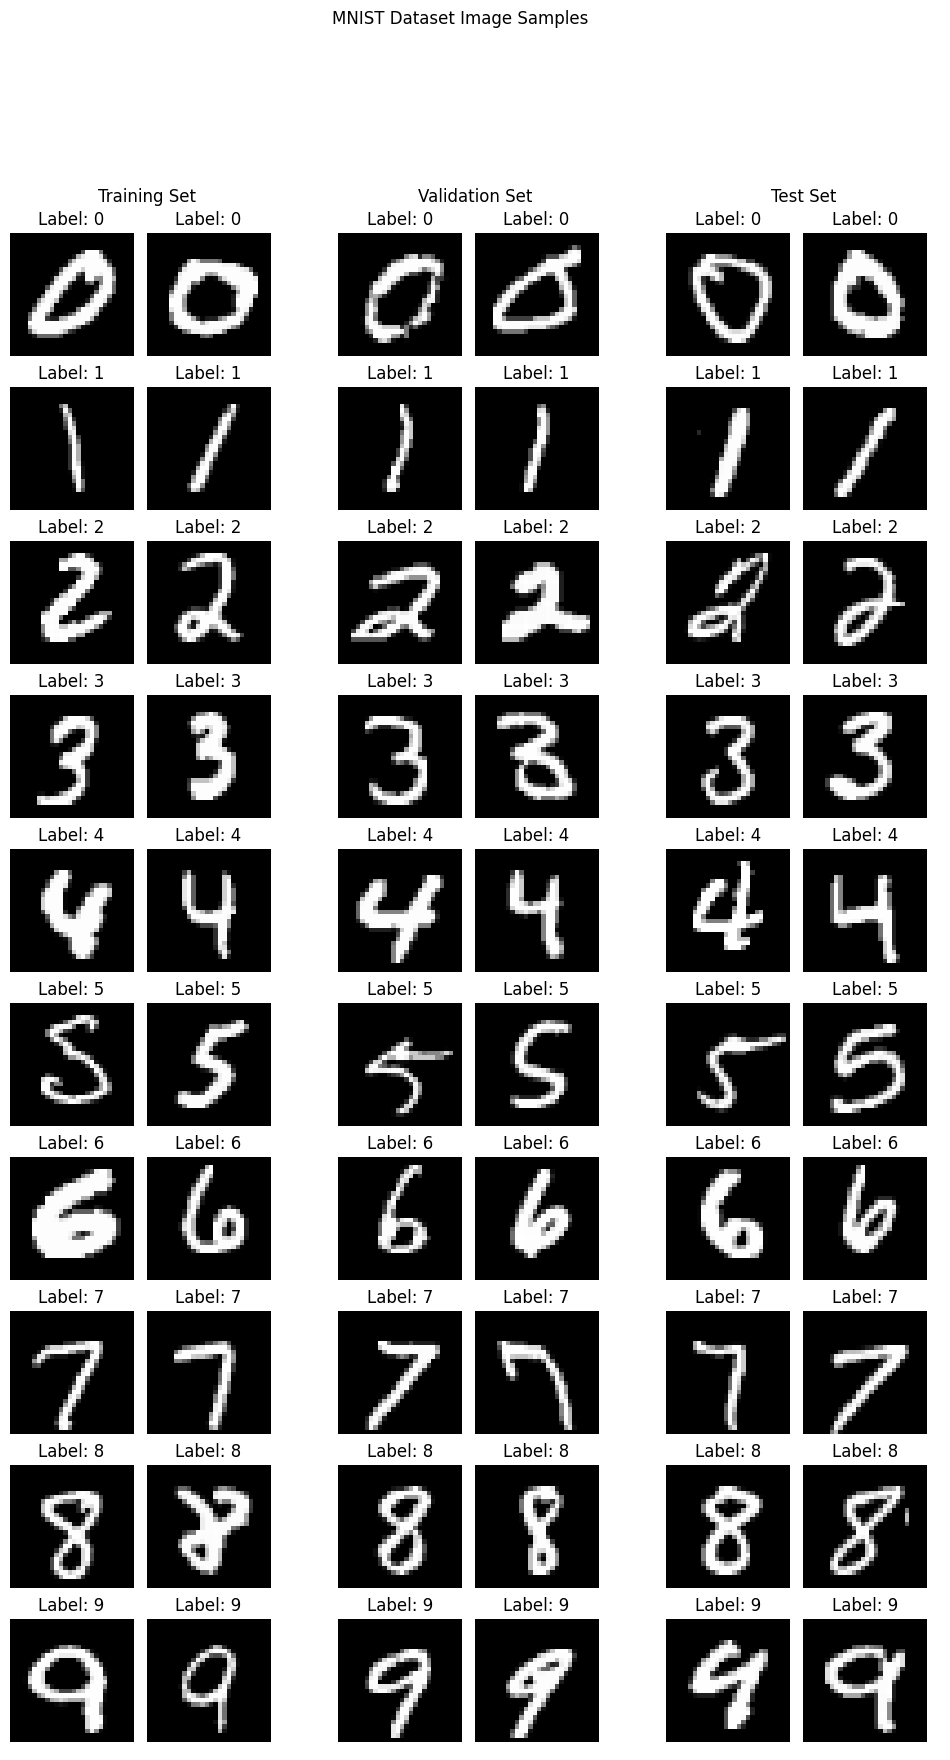

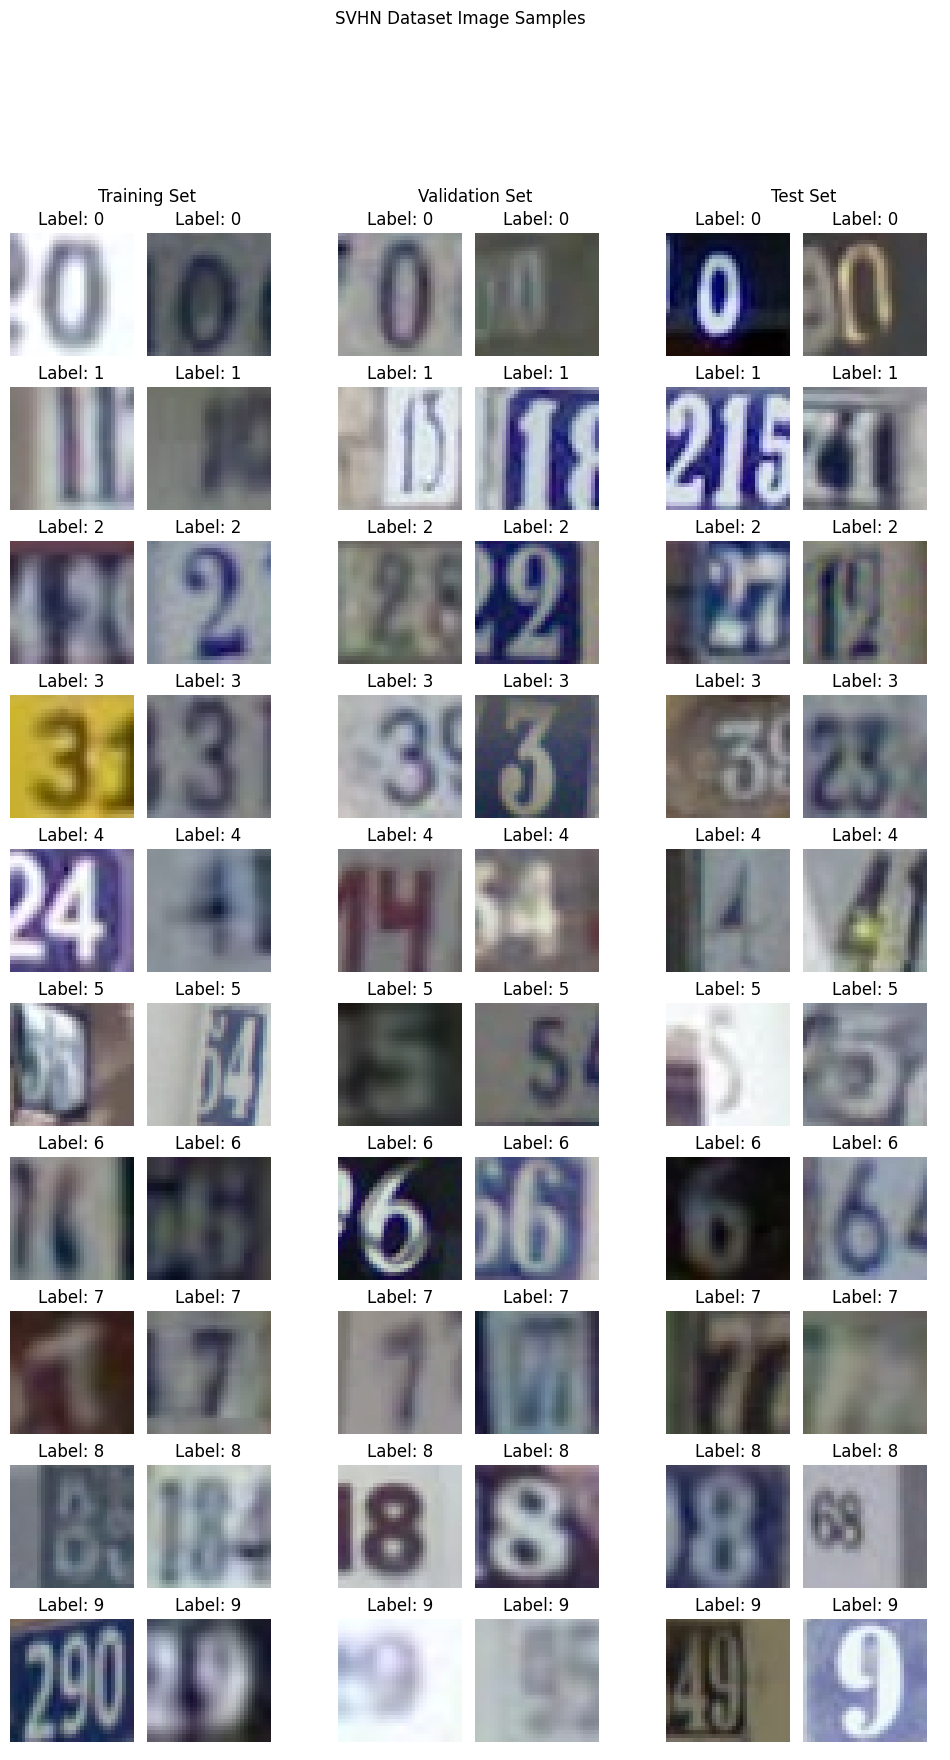

In [8]:
# Function to plot images in a 1x3 grid for a dataset
def plot_dataset_grid(dataset, title, num_images=2):
    fig, axes = plt.subplots(1, 3, figsize=(12, 20))  # 1x3 grid
    fig.suptitle(title)
    splits = ['Training Set', 'Validation Set', 'Test Set']

    for i, (data, split_name) in enumerate(zip(dataset, splits)):
        data_loader = DataLoader(data, batch_size=1, shuffle=False)
        class_counts = {i: 0 for i in range(10)}
        ax = axes[i]
        ax.set_title(split_name)
        ax.axis('off')  # Hide axes for the main grid

        # Create a subgrid for the images
        subgrid = ax.inset_axes([0, 0, 1, 1])  # Create a subplot within the main grid
        subgrid.axis('off')  # Hide axes for the subgrid

        for img, label in data_loader:
            label = label.item()  # Convert tensor to integer
            if class_counts[label] < num_images:
                img_ax = subgrid.inset_axes([class_counts[label] * 0.5, (9 - label) * 0.1, 0.45, 0.09])  # Position each image
                if img.shape[1] == 1:  # Grayscale image
                    img_ax.imshow(img.squeeze().numpy(), cmap='gray')
                else:  # RGB image
                    img_ax.imshow(np.transpose(img.squeeze().numpy(), (1, 2, 0)))
                img_ax.set_title(f'Label: {label}')
                img_ax.axis('off')
                class_counts[label] += 1
            if all(count >= num_images for count in class_counts.values()):
                break
    plt.show()

# Define the datasets as lists of splits
mnist_splits = [mnist_train, mnist_val, mnist_test]
svhn_splits = [svhn_train, svhn_val, svhn_test]

# Plot MNIST and SVHN datasets in 1x3 grids
plot_dataset_grid(mnist_splits, 'MNIST Dataset Image Samples')
plot_dataset_grid(svhn_splits, 'SVHN Dataset Image Samples')

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


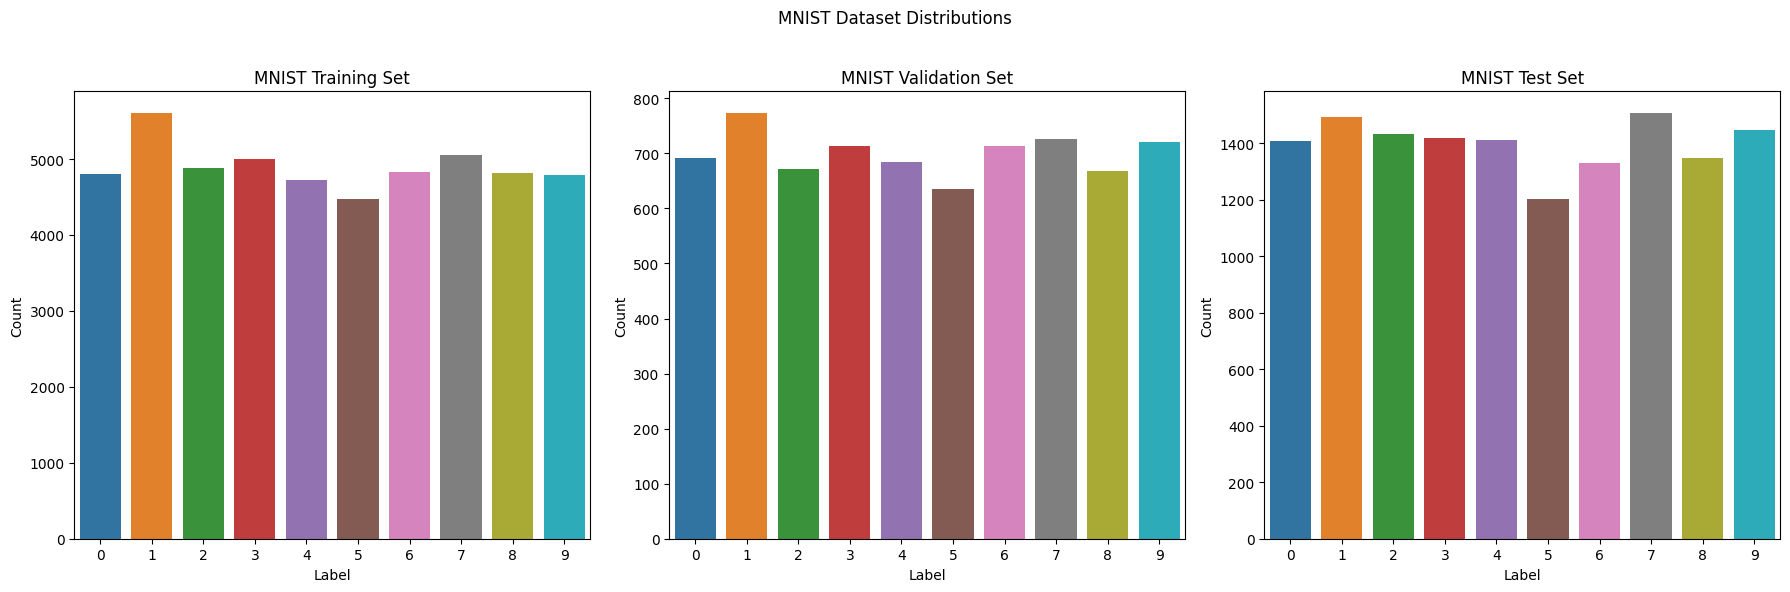

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


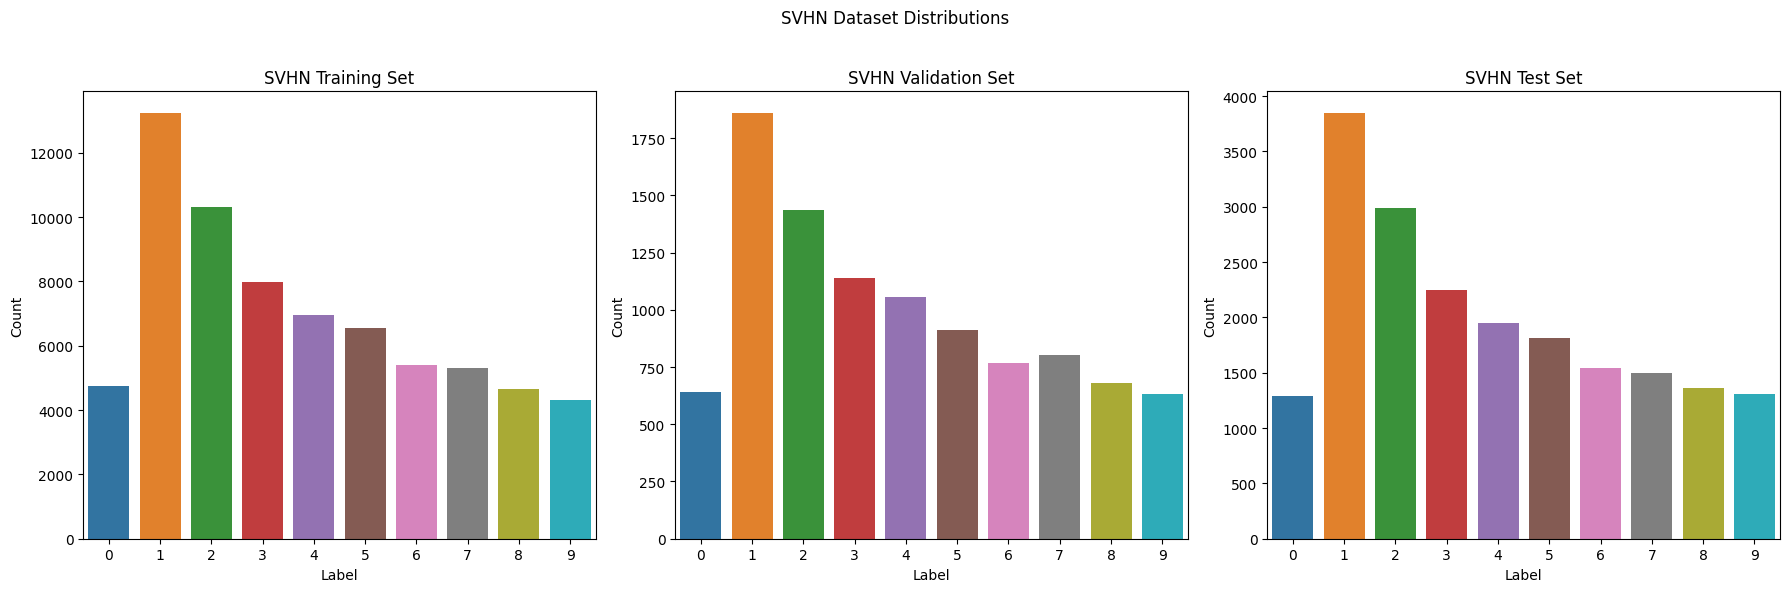

In [9]:
# Function to plot label distribution
def plot_label_distribution(dataset, title, ax):
    labels = [label for _, label in DataLoader(dataset, batch_size=1)]
    labels = [label.item() for label in labels]
    sns.countplot(x=labels, ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Label')
    ax.set_ylabel('Count')

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('MNIST Dataset Distributions')
plot_label_distribution(mnist_train, 'MNIST Training Set', axes[0])
plot_label_distribution(mnist_val, 'MNIST Validation Set', axes[1])
plot_label_distribution(mnist_test, 'MNIST Test Set', axes[2])
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('SVHN Dataset Distributions')
plot_label_distribution(svhn_train, 'SVHN Training Set', axes[0])
plot_label_distribution(svhn_val, 'SVHN Validation Set', axes[1])
plot_label_distribution(svhn_test, 'SVHN Test Set', axes[2])
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# 2. Building and Training the CNN Model

## Define the CNN Model

In [8]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [17]:
class CNN(nn.Module):
    def __init__(self, activation='ReLU', input_size=(3, 28, 28)):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        # Define activation function
        if activation == 'ReLU':
            self.activation = nn.ReLU()
        elif activation == 'LeakyReLU':
            self.activation = nn.LeakyReLU(negative_slope=0.1)
        elif activation == 'ELU':
            self.activation = nn.ELU(alpha=1.0)
        else:
            raise ValueError("Unsupported activation function")

        # Calculate the size of the tensor after conv and pool layers
        self.fc1_input_size = self._calculate_fc1_input_size(input_size)

        # Define the fully connected layer
        self.fc1 = nn.Linear(self.fc1_input_size, 128)
        self.fc2 = nn.Linear(128, 10)

    def _calculate_fc1_input_size(self, input_size):
        # Create a dummy input to calculate the size after conv and pool layers
        with torch.no_grad():
            dummy_input = torch.zeros(1, *input_size)
            dummy_input = self.pool(self.activation(self.bn1(self.conv1(dummy_input))))
            dummy_input = self.pool(self.activation(self.bn2(self.conv2(dummy_input))))
            dummy_input = torch.flatten(dummy_input, 1)
            return dummy_input.size(1)

    def forward(self, x):
        # Ensure input tensor is on the correct device
        x = x.to(device)  # Move input to the device (GPU if available)

        # Pass through the first set of conv, batch norm, and pool layers
        x = self.pool(self.activation(self.bn1(self.conv1(x))))
        # Pass through the second set of conv, batch norm, and pool layers
        x = self.pool(self.activation(self.bn2(self.conv2(x))))

        # Flatten the tensor for the fully connected layer
        x = torch.flatten(x, 1)

        # Pass through the fully connected layers
        x = self.activation(self.fc1(x))
        x = self.fc2(x)

        return F.log_softmax(x, dim=1)

# Example usage for RGB images (3 channels)
model = CNN(input_size=(3, 32, 32))
summary(model, (3, 32, 32))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
         MaxPool2d-4           [-1, 32, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          18,496
       BatchNorm2d-6           [-1, 64, 16, 16]             128
              ReLU-7           [-1, 64, 16, 16]               0
         MaxPool2d-8             [-1, 64, 8, 8]               0
            Linear-9                  [-1, 128]         524,416
             ReLU-10                  [-1, 128]               0
           Linear-11                   [-1, 10]           1,290
Total params: 545,290
Trainable params: 545,290
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/

In [18]:
model = CNN()
summary(model, (3, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             896
       BatchNorm2d-2           [-1, 32, 28, 28]              64
              ReLU-3           [-1, 32, 28, 28]               0
         MaxPool2d-4           [-1, 32, 14, 14]               0
            Conv2d-5           [-1, 64, 14, 14]          18,496
       BatchNorm2d-6           [-1, 64, 14, 14]             128
              ReLU-7           [-1, 64, 14, 14]               0
         MaxPool2d-8             [-1, 64, 7, 7]               0
            Linear-9                  [-1, 128]         401,536
             ReLU-10                  [-1, 128]               0
           Linear-11                   [-1, 10]           1,290
Total params: 422,410
Trainable params: 422,410
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/

## The Training Function

In [23]:
# Initialize variables to track metrics for the best model
best_train_losses = []
best_train_accuracies = []
best_val_losses = []
best_val_accuracies = []

def train_model(train_loader, val_loader, hyperparams, train_metrics_file, val_metrics_file, best_accuracy, best_model_state, best_hyperparams):
    model = CNN(activation=hyperparams['activation']).to(device)  # Move model to GPU
    criterion = nn.CrossEntropyLoss()

    # Set optimizer
    if hyperparams['optimizer'] == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=hyperparams['learning_rate'], momentum=0.9)
    elif hyperparams['optimizer'] == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=hyperparams['learning_rate'])

    # Lists to store metrics
    train_losses, val_losses = [], []
    train_accuracies, train_precisions, train_recalls = [], [], []
    val_accuracies, val_precisions, val_recalls = [], [], []

    best_val_accuracy = 0.0  # Track the best validation accuracy
    best_val_loss = float('inf')  # Track the best validation loss for early stopping
    epochs_no_improve = 0  # Track the number of epochs with no improvement

    # Open the metrics files in append mode
    with open(train_metrics_file, 'a') as train_file, open(val_metrics_file, 'a') as val_file:
        # Write hyperparameters as a heading in both files
        train_file.write(f"\n Training with LR: {hyperparams['learning_rate']}, Batch Size: {hyperparams['batch_size']}, Optimizer: {hyperparams['optimizer']}, Activation: {hyperparams['activation']}\n")
        train_file.write("Epoch,Train Loss,Train Accuracy,Train Precision,Train Recall\n")

        val_file.write(f"\n Training with LR: {hyperparams['learning_rate']}, Batch Size: {hyperparams['batch_size']}, Optimizer: {hyperparams['optimizer']}, Activation: {hyperparams['activation']}\n")
        val_file.write("Epoch,Val Loss,Val Accuracy,Val Precision,Val Recall\n")

        for epoch in range(50):
            model.train()
            running_loss = 0.0
            train_preds, train_labels = [], []
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

                # Collect predictions and labels for training metrics
                _, predicted = torch.max(outputs.data, 1)
                train_preds.extend(predicted.cpu().numpy())
                train_labels.extend(labels.cpu().numpy())

            # Calculate training metrics
            train_loss = running_loss / len(train_loader)
            train_accuracy = 100 * (np.array(train_preds) == np.array(train_labels)).mean()
            train_precision = precision_score(train_labels, train_preds, average='macro')
            train_recall = recall_score(train_labels, train_preds, average='macro')

            train_losses.append(train_loss)
            train_accuracies.append(train_accuracy)
            train_precisions.append(train_precision)
            train_recalls.append(train_recall)

            # Save training metrics to file
            train_file.write(f"{epoch+1},{train_loss},{train_accuracy},{train_precision},{train_recall}\n")

            # Validation
            model.eval()
            val_loss = 0.0
            val_preds, val_labels = [], []
            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
                    outputs = model(inputs)
                    val_loss += criterion(outputs, labels).item()
                    _, predicted = torch.max(outputs.data, 1)
                    val_preds.extend(predicted.cpu().numpy())
                    val_labels.extend(labels.cpu().numpy())

            # Calculate validation metrics
            val_losses.append(val_loss / len(val_loader))
            val_accuracy = 100 * (np.array(val_preds) == np.array(val_labels)).mean()
            val_precision = precision_score(val_labels, val_preds, average='macro')
            val_recall = recall_score(val_labels, val_preds, average='macro')

            val_accuracies.append(val_accuracy)
            val_precisions.append(val_precision)
            val_recalls.append(val_recall)

            # Save validation metrics to file
            val_file.write(f"{epoch+1},{val_losses[-1]},{val_accuracy},{val_precision},{val_recall}\n")

            # Check for early stopping
            patience = 5
            if val_losses[-1] < best_val_loss:
                best_val_loss = val_losses[-1]
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1

            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

            # Update the best model globally
            if val_accuracy > best_accuracy:
                best_accuracy = val_accuracy
                best_model_state = model.state_dict()
                best_hyperparams = hyperparams

                # Store metrics for the best model
                best_train_losses.clear()
                best_train_accuracies.clear()
                best_val_losses.clear()
                best_val_accuracies.clear()

                best_train_losses.extend(train_losses)
                best_train_accuracies.extend(train_accuracies)
                best_val_losses.extend(val_losses)
                best_val_accuracies.extend(val_accuracies)

                print(f"New best model found with validation accuracy: {best_accuracy} and hyperparameters: {best_hyperparams}")

            # Print metrics
            print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Train Precision: {train_precision:.4f}, Train Recall: {train_recall:.4f}")
            print(f"Epoch {epoch+1}, Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracy:.2f}%, Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}")

    return train_losses, train_accuracies, val_losses, val_accuracies, best_accuracy, best_model_state, best_hyperparams

## Train the Model on the MNIST dataset with Different Hyperparameters

In [11]:
hyperparameters = {
    'learning_rate': [0.001, 0.005, 0.01],
    'batch_size': [32, 64, 128],
    'optimizer': ['SGD', 'Adam'],
    'activation': ['ReLU', 'LeakyReLU', 'ELU']
}

In [14]:
# Define paths for saving metrics
mnist_train_metrics = "mnist_train_metrics.txt"
mnist_val_metrics = "mnist_val_metrics.txt"
mnist_model_path = "mnist_best_model.pth"

# Clear the files before starting
open(mnist_train_metrics, 'w').close()
open(mnist_val_metrics, 'w').close()

# Initialize global best tracking variables
best_accuracy = 0
best_model_state = None
best_hyperparams = None

# Iterate over hyperparameters
for lr in hyperparameters['learning_rate']:
    for batch_size in hyperparameters['batch_size']:
        for optimizer in hyperparameters['optimizer']:
            for activation in hyperparameters['activation']:
                print(f"Training with LR: {lr}, Batch Size: {batch_size}, Optimizer: {optimizer}, Activation: {activation}")

                # Create data loaders
                train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
                val_loader = DataLoader(mnist_val, batch_size=batch_size, shuffle=True)

                # Train the model
                train_losses, train_accuracies, val_losses, val_accuracies, best_accuracy, best_model_state, best_hyperparams = train_model(
                    train_loader, val_loader, {'learning_rate': lr, 'batch_size': batch_size, 'optimizer': optimizer, 'activation': activation},
                      mnist_train_metrics, mnist_val_metrics, best_accuracy, best_model_state, best_hyperparams)

# Save the best model
torch.save(best_model_state, mnist_model_path)
print(f"Best Hyperparameters: {best_hyperparams}, Best Validation Accuracy: {best_accuracy}")
print(f"Best model saved to {mnist_model_path}")


Training with LR: 0.001, Batch Size: 32, Optimizer: SGD, Activation: ReLU
New best model found with validation accuracy: 94.6 and hyperparameters: {'learning_rate': 0.001, 'batch_size': 32, 'optimizer': 'SGD', 'activation': 'ReLU'}
Epoch 1, Train Loss: 0.7661, Train Accuracy: 85.14%, Train Precision: 0.8539, Train Recall: 0.8489
Epoch 1, Val Loss: 0.2738, Val Accuracy: 94.60%, Val Precision: 0.9457, Val Recall: 0.9455
New best model found with validation accuracy: 96.02857142857142 and hyperparameters: {'learning_rate': 0.001, 'batch_size': 32, 'optimizer': 'SGD', 'activation': 'ReLU'}
Epoch 2, Train Loss: 0.2167, Train Accuracy: 95.19%, Train Precision: 0.9514, Train Recall: 0.9514
Epoch 2, Val Loss: 0.1695, Val Accuracy: 96.03%, Val Precision: 0.9601, Val Recall: 0.9599
New best model found with validation accuracy: 96.68571428571428 and hyperparameters: {'learning_rate': 0.001, 'batch_size': 32, 'optimizer': 'SGD', 'activation': 'ReLU'}
Epoch 3, Train Loss: 0.1513, Train Accuracy: 9

## Plot Training and Validation Metrics

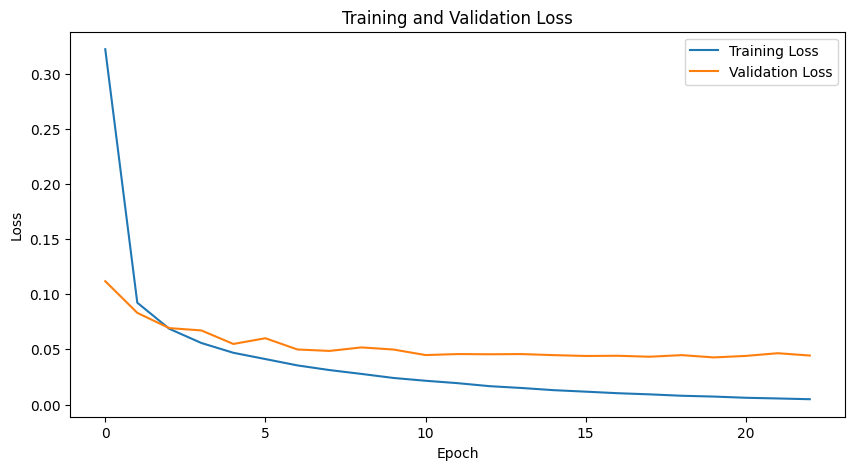

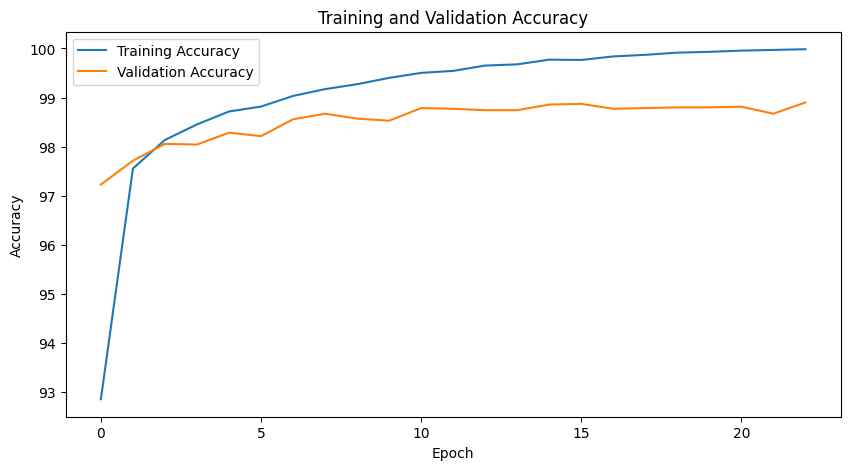

In [15]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(best_train_losses, label='Training Loss')
plt.plot(best_val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(best_train_accuracies, label='Training Accuracy')
plt.plot(best_val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

## Evaluate the Best Model on Test Set

In [10]:
mnist_best_hyperparams = {'learning_rate': 0.01, 'batch_size': 64, 'optimizer': 'SGD', 'activation': 'LeakyReLU'}
mnist_model_path = "mnist_best_model.pth"

In [24]:
# Step 1: Dynamically Demonstrate Inference on Random Test Samples
def demonstrate_inference(test_loader, model, num_samples=5):
    model.eval()
    data_iter = iter(test_loader)
    images, labels = next(data_iter)
    
    with torch.no_grad():
        outputs = model(images)
        probabilities = torch.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)
    
    # Plot the results
    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i+1)
        # Convert tensor to numpy and transpose to (H, W, C) for RGB images
        img = images[i].cpu().numpy().transpose(1, 2, 0)
        # Normalize if necessary (assuming images are in [0, 1] or [0, 255])
        if img.max() > 1:
            img = img / 255.0
        plt.imshow(img)
        plt.title(f"Pred: {predicted[i]}, True: {labels[i]}")
        plt.axis('off')
    plt.show()


# Step 2: Create Confusion Matrices
def plot_confusion_matrix(labels, preds, class_names):
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Step 3: Visualize Probability Maps (Softmax Scores)
def visualize_probability_maps(probabilities, labels, preds, num_samples=5):
    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i+1)
        plt.bar(range(10), probabilities[i])
        plt.title(f"True: {labels[i]}, Pred: {preds[i]}")
        plt.xlabel('Class')
        plt.ylabel('Probability')
        plt.ylim(0, 1)
    plt.show()

# Step 4: Analyze Classification Performance Per Class
def analyze_per_class_performance(labels, preds, class_names):
    precision = precision_score(labels, preds, average=None)
    recall = recall_score(labels, preds, average=None)
    f1 = f1_score(labels, preds, average=None)
    
    print("Class-wise Performance:")
    for i, class_name in enumerate(class_names):
        print(f"Class {class_name}: Precision = {precision[i]:.4f}, Recall = {recall[i]:.4f}, F1 = {f1[i]:.4f}")

# Step 5: Identify and Visualize Misclassified Examples for Each Class
def visualize_misclassified_examples(images, true_labels, pred_labels, class_names, num_samples=5):
    misclassified_indices = np.where(pred_labels != true_labels)[0]  # Indices of misclassified samples
    
    for class_idx, class_name in enumerate(class_names):
        # Find misclassified examples for the current class
        class_misclassified_indices = misclassified_indices[true_labels[misclassified_indices] == class_idx]
        
        if len(class_misclassified_indices) == 0:
            print(f"No misclassified examples found for class {class_name}.")
            continue
        
        # Randomly select a few misclassified examples for visualization
        selected_indices = np.random.choice(class_misclassified_indices, size=min(num_samples, len(class_misclassified_indices)), replace=False)
        
        # Plot the misclassified examples
        plt.figure(figsize=(15, 3))
        plt.suptitle(f"Misclassified Examples for Class {class_name}", fontsize=16)
        for i, idx in enumerate(selected_indices):
            plt.subplot(1, num_samples, i+1)
            img = images[idx].transpose(1, 2, 0)  # Convert (C, H, W) to (H, W, C) for RGB images
            if img.max() > 1:
                img = img / 255.0  # Normalize if necessary
            plt.imshow(img)
            plt.title(f"True: {class_name}, Pred: {class_names[pred_labels[idx]]}")
            plt.axis('off')
        plt.show()


Test Accuracy: 98.54%, Test Precision: 0.9854, Test Recall: 0.9854


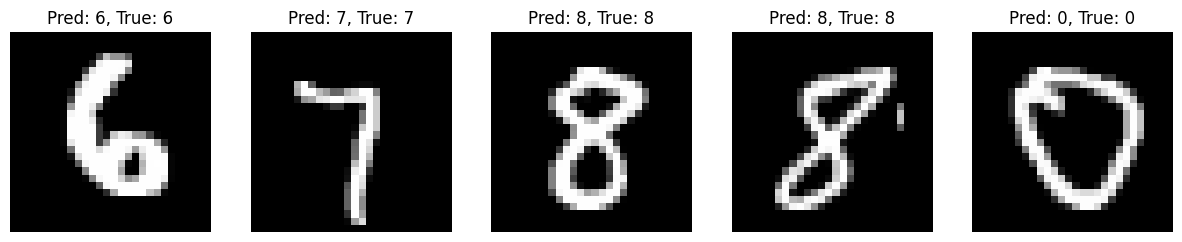

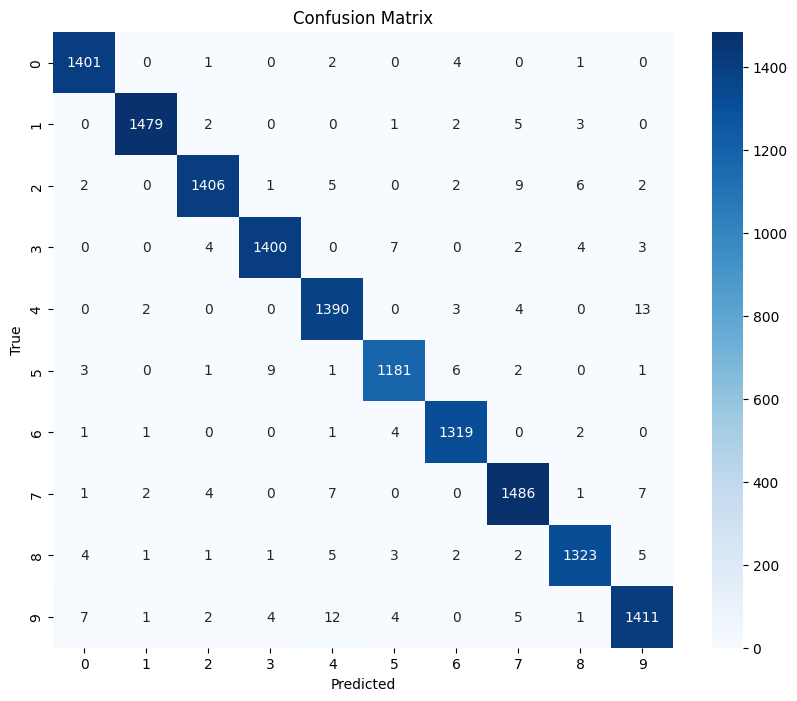

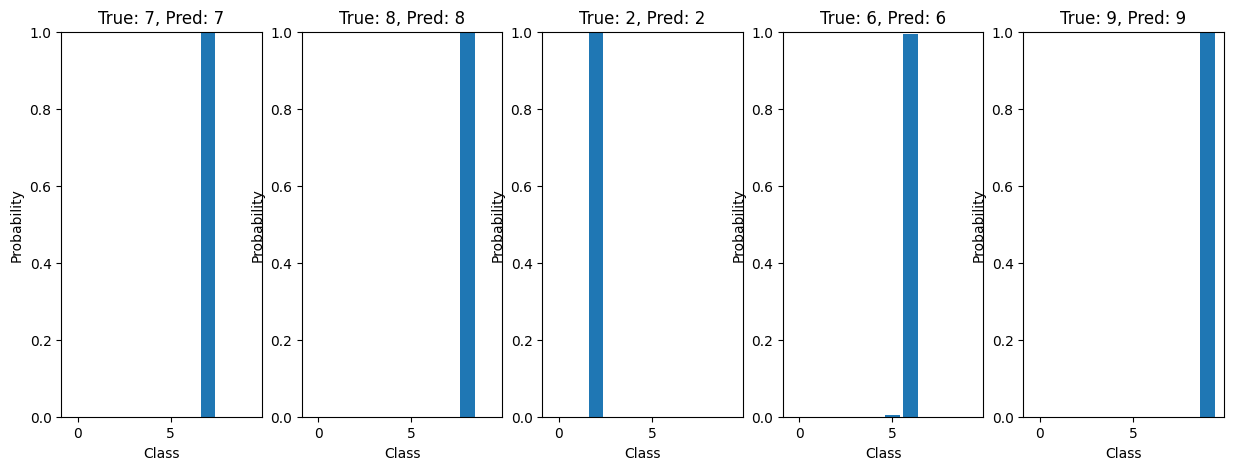

Class-wise Performance:
Class 0: Precision = 0.9873, Recall = 0.9943, F1 = 0.9908
Class 1: Precision = 0.9953, Recall = 0.9913, F1 = 0.9933
Class 2: Precision = 0.9894, Recall = 0.9812, F1 = 0.9853
Class 3: Precision = 0.9894, Recall = 0.9859, F1 = 0.9877
Class 4: Precision = 0.9768, Recall = 0.9844, F1 = 0.9806
Class 5: Precision = 0.9842, Recall = 0.9809, F1 = 0.9825
Class 6: Precision = 0.9858, Recall = 0.9932, F1 = 0.9895
Class 7: Precision = 0.9809, Recall = 0.9854, F1 = 0.9831
Class 8: Precision = 0.9866, Recall = 0.9822, F1 = 0.9844
Class 9: Precision = 0.9785, Recall = 0.9751, F1 = 0.9768


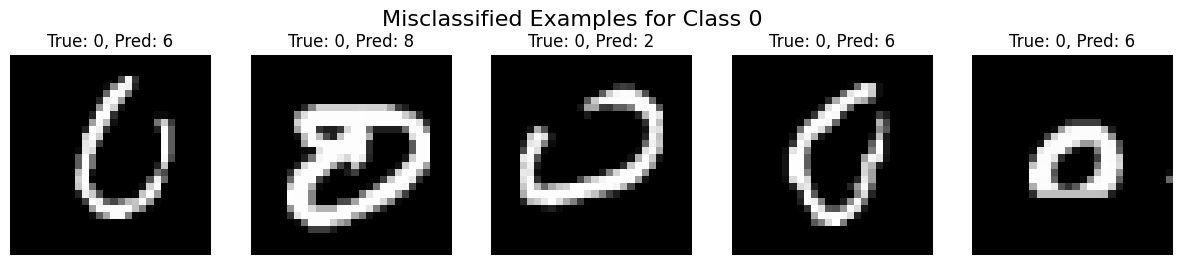

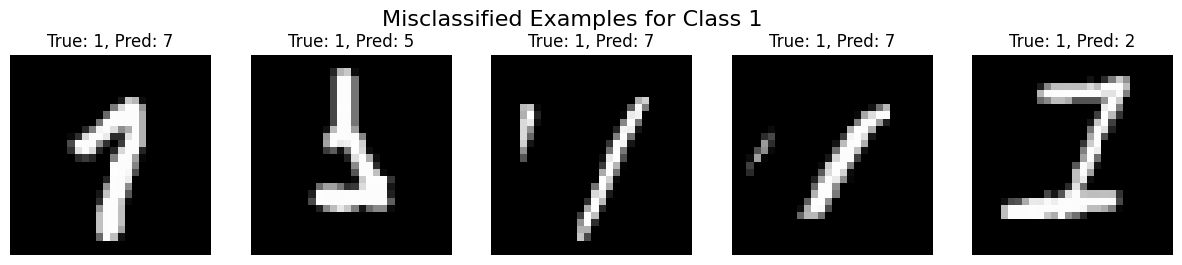

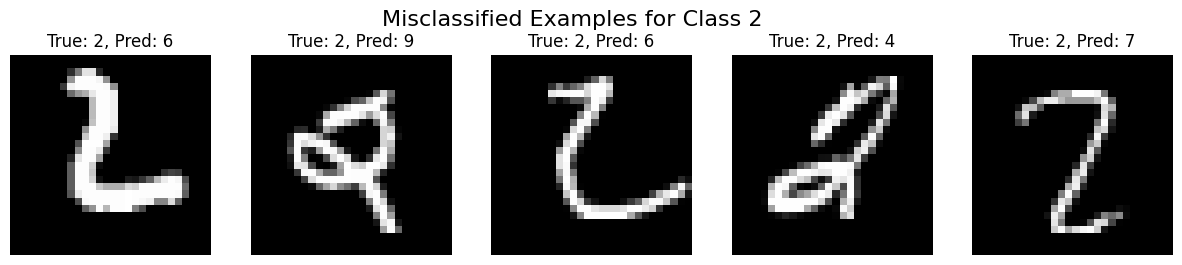

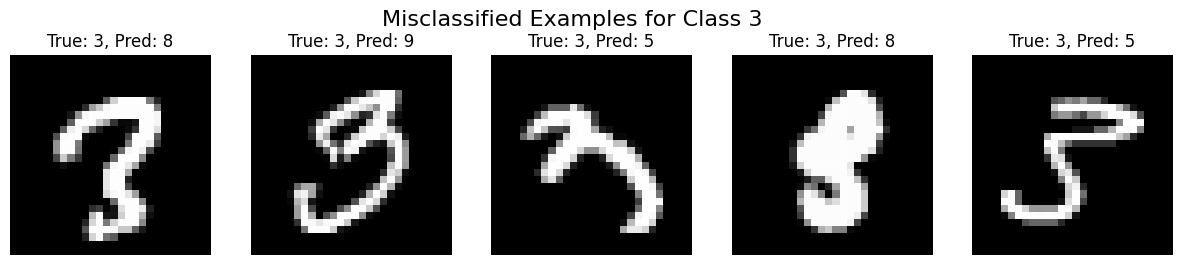

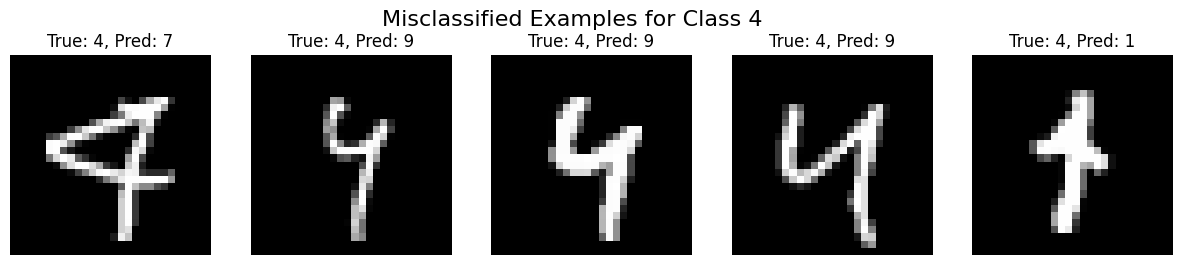

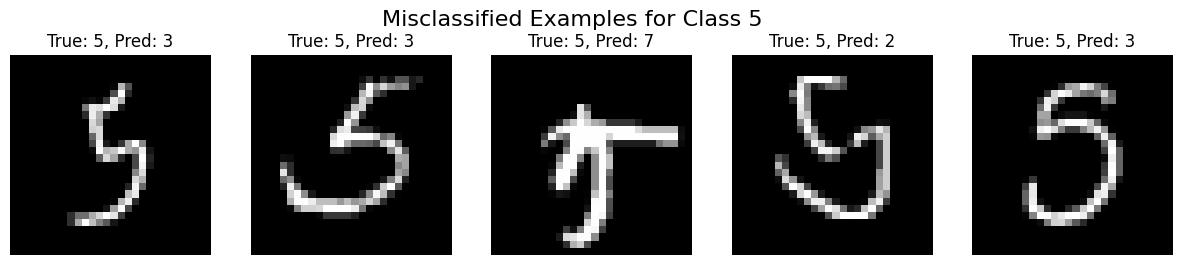

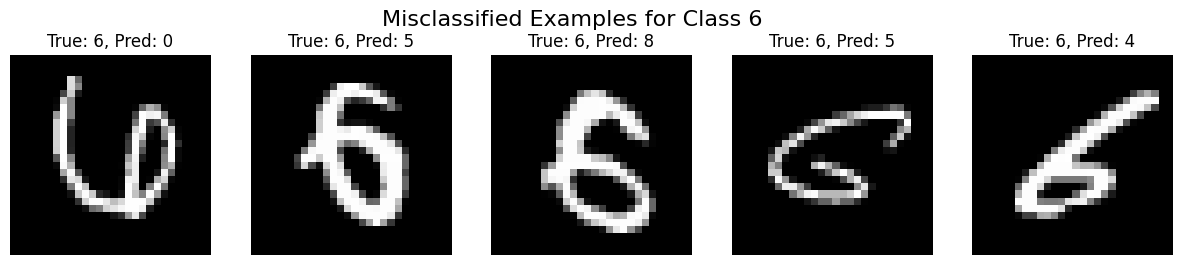

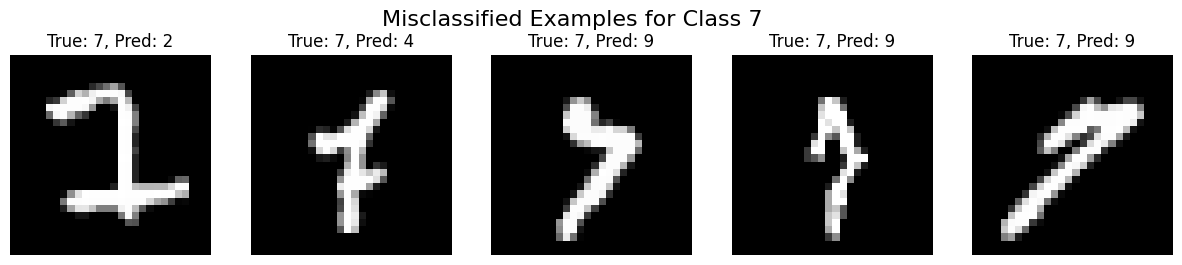

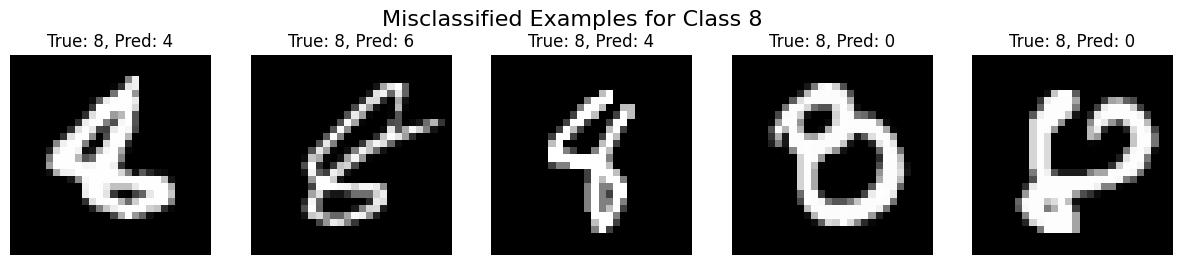

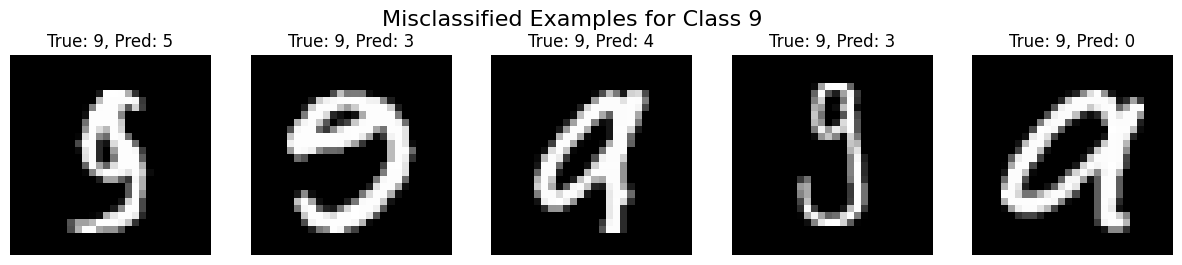

In [25]:
# Load the best model
mnist_best_model = CNN(activation=mnist_best_hyperparams['activation'])
mnist_best_model.load_state_dict(torch.load(mnist_model_path, map_location=torch.device('cpu'), weights_only=True))
mnist_best_model.eval()

# Evaluate on test set
mnist_test_loader = DataLoader(mnist_test, batch_size=mnist_best_hyperparams['batch_size'], shuffle=False)  # Set shuffle=False for consistent indexing
all_preds, all_labels = [], []
all_images, all_probabilities = [], []  # Store images and softmax probabilities

with torch.no_grad():
    for inputs, labels in mnist_test_loader:
        outputs = mnist_best_model(inputs)
        probabilities = torch.softmax(outputs, dim=1)  # Get softmax probabilities
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_images.extend(inputs.cpu().numpy())  # Store images
        all_probabilities.extend(probabilities.cpu().numpy())  # Store probabilities

# Convert lists to numpy arrays for easier manipulation
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_images = np.array(all_images)
all_probabilities = np.array(all_probabilities)

# Calculate test metrics
test_accuracy = 100 * (np.array(all_preds) == np.array(all_labels)).mean()
test_precision = precision_score(all_labels, all_preds, average='macro')
test_recall = recall_score(all_labels, all_preds, average='macro')

print(f"Test Accuracy: {test_accuracy:.2f}%, Test Precision: {test_precision:.4f}, Test Recall: {test_recall:.4f}")

# Demonstrate inference on random samples
demonstrate_inference(mnist_test_loader, mnist_best_model)

# Plot confusion matrix for MNIST
class_names = [str(i) for i in range(10)]  # MNIST classes are digits 0-9
plot_confusion_matrix(all_labels, all_preds, class_names)

# Visualize probability maps for random samples
random_indices = np.random.choice(len(all_probabilities), size=5, replace=False)
visualize_probability_maps(np.array(all_probabilities)[random_indices], np.array(all_labels)[random_indices], np.array(all_preds)[random_indices])

# Analyze performance per class
analyze_per_class_performance(all_labels, all_preds, class_names)

# Visualize misclassified examples for each class
visualize_misclassified_examples(all_images, all_labels, all_preds, class_names, num_samples=5)

## Similar Process for the SVHN dataset.

In [11]:
# Define paths for saving metrics
svhn_train_metrics = "svhn_train_metrics.txt"
svhn_val_metrics = "svhn_val_metrics.txt"
svhn_model_path = "svhn_best_model.pth"

# Clear the files before starting
open(svhn_train_metrics, 'w').close()
open(svhn_val_metrics, 'w').close()

# Initialize global best tracking variables
best_accuracy = 0
best_model_state = None
best_hyperparams = None

# Iterate over hyperparameters
for lr in hyperparameters['learning_rate']:
    for batch_size in hyperparameters['batch_size']:
        for optimizer in hyperparameters['optimizer']:
            for activation in hyperparameters['activation']:
                print(f"Training with LR: {lr}, Batch Size: {batch_size}, Optimizer: {optimizer}, Activation: {activation}")

                # Create data loaders
                train_loader = DataLoader(svhn_train, batch_size=batch_size, shuffle=True)
                val_loader = DataLoader(svhn_val, batch_size=batch_size, shuffle=False)

                # Train the model
                train_losses, train_accuracies, val_losses, val_accuracies, best_accuracy, best_model_state, best_hyperparams = train_model(
                    train_loader, val_loader, {'learning_rate': lr, 'batch_size': batch_size, 'optimizer': optimizer, 'activation': activation},
                      svhn_train_metrics, svhn_val_metrics, best_accuracy, best_model_state, best_hyperparams)

# Save the best model
torch.save(best_model_state, svhn_model_path)
print(f"Best Hyperparameters: {best_hyperparams}, Best Validation Accuracy: {best_accuracy}")
print(f"Best model saved to {svhn_model_path}")


Training with LR: 0.001, Batch Size: 32, Optimizer: SGD, Activation: ReLU
New best model found with validation accuracy: 53.995076096687555 and hyperparameters: {'learning_rate': 0.001, 'batch_size': 32, 'optimizer': 'SGD', 'activation': 'ReLU'}
Epoch 1, Train Loss: 1.9779, Train Accuracy: 32.00%, Train Precision: 0.4646, Train Recall: 0.2179
Epoch 1, Val Loss: 1.5187, Val Accuracy: 54.00%, Val Precision: 0.6058, Val Recall: 0.4338
New best model found with validation accuracy: 73.05282005371531 and hyperparameters: {'learning_rate': 0.001, 'batch_size': 32, 'optimizer': 'SGD', 'activation': 'ReLU'}
Epoch 2, Train Loss: 1.1789, Train Accuracy: 66.05%, Train Precision: 0.6841, Train Recall: 0.5926
Epoch 2, Val Loss: 0.9792, Val Accuracy: 73.05%, Val Precision: 0.7449, Val Recall: 0.6834
New best model found with validation accuracy: 75.8616830796777 and hyperparameters: {'learning_rate': 0.001, 'batch_size': 32, 'optimizer': 'SGD', 'activation': 'ReLU'}
Epoch 3, Train Loss: 0.8745, Trai

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1, Train Loss: 2.1703, Train Accuracy: 22.65%, Train Precision: 0.1735, Train Recall: 0.1268
Epoch 1, Val Loss: 2.0566, Val Accuracy: 27.73%, Val Precision: 0.2372, Val Recall: 0.1635
Epoch 2, Train Loss: 1.8015, Train Accuracy: 40.59%, Train Precision: 0.5118, Train Recall: 0.2924
Epoch 2, Val Loss: 1.5392, Val Accuracy: 51.97%, Val Precision: 0.6171, Val Recall: 0.4243
Epoch 3, Train Loss: 1.3010, Train Accuracy: 63.03%, Train Precision: 0.6625, Train Recall: 0.5519
Epoch 3, Val Loss: 1.1738, Val Accuracy: 65.77%, Val Precision: 0.7068, Val Recall: 0.5986
Epoch 4, Train Loss: 1.0204, Train Accuracy: 72.29%, Train Precision: 0.7305, Train Recall: 0.6718
Epoch 4, Val Loss: 1.0335, Val Accuracy: 70.15%, Val Precision: 0.7289, Val Recall: 0.6583
Epoch 5, Train Loss: 0.8800, Train Accuracy: 75.73%, Train Precision: 0.7574, Train Recall: 0.7162
Epoch 5, Val Loss: 0.9855, Val Accuracy: 70.02%, Val Precision: 0.7604, Val Recall: 0.6558
Epoch 6, Train Loss: 0.7990, Train Accuracy: 77.76

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1, Train Loss: 2.1586, Train Accuracy: 22.88%, Train Precision: 0.2142, Train Recall: 0.1317
Epoch 1, Val Loss: 2.0385, Val Accuracy: 30.54%, Val Precision: 0.2618, Val Recall: 0.1881
Epoch 2, Train Loss: 1.7785, Train Accuracy: 42.32%, Train Precision: 0.5041, Train Recall: 0.3119
Epoch 2, Val Loss: 1.5394, Val Accuracy: 55.57%, Val Precision: 0.5687, Val Recall: 0.4710
Epoch 3, Train Loss: 1.3012, Train Accuracy: 62.64%, Train Precision: 0.6577, Train Recall: 0.5483
Epoch 3, Val Loss: 1.1385, Val Accuracy: 68.32%, Val Precision: 0.6926, Val Recall: 0.6311
Epoch 4, Train Loss: 1.0200, Train Accuracy: 71.76%, Train Precision: 0.7275, Train Recall: 0.6648
Epoch 4, Val Loss: 1.0935, Val Accuracy: 66.48%, Val Precision: 0.7615, Val Recall: 0.6001
Epoch 5, Train Loss: 0.8772, Train Accuracy: 75.51%, Train Precision: 0.7575, Train Recall: 0.7146
Epoch 5, Val Loss: 0.8701, Val Accuracy: 75.60%, Val Precision: 0.7499, Val Recall: 0.7276
Epoch 6, Train Loss: 0.7985, Train Accuracy: 77.47

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1, Train Loss: 2.2097, Train Accuracy: 20.73%, Train Precision: 0.1245, Train Recall: 0.1138
Epoch 1, Val Loss: 2.1670, Val Accuracy: 24.22%, Val Precision: 0.3040, Val Recall: 0.1376


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 2, Train Loss: 2.0900, Train Accuracy: 27.47%, Train Precision: 0.2556, Train Recall: 0.1653
Epoch 2, Val Loss: 1.9916, Val Accuracy: 33.36%, Val Precision: 0.2848, Val Recall: 0.2151
Epoch 3, Train Loss: 1.8499, Train Accuracy: 38.59%, Train Precision: 0.4827, Train Recall: 0.2661
Epoch 3, Val Loss: 1.7138, Val Accuracy: 44.80%, Val Precision: 0.5358, Val Recall: 0.3295
Epoch 4, Train Loss: 1.5751, Train Accuracy: 50.90%, Train Precision: 0.5823, Train Recall: 0.3983
Epoch 4, Val Loss: 1.4579, Val Accuracy: 57.34%, Val Precision: 0.6323, Val Recall: 0.4732
Epoch 5, Train Loss: 1.3480, Train Accuracy: 61.11%, Train Precision: 0.6558, Train Recall: 0.5212
Epoch 5, Val Loss: 1.2710, Val Accuracy: 63.10%, Val Precision: 0.6888, Val Recall: 0.5442
Epoch 6, Train Loss: 1.1827, Train Accuracy: 66.99%, Train Precision: 0.6978, Train Recall: 0.5980
Epoch 6, Val Loss: 1.1534, Val Accuracy: 69.40%, Val Precision: 0.7130, Val Recall: 0.6349
Epoch 7, Train Loss: 1.0534, Train Accuracy: 71.38

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1, Train Loss: 2.2200, Train Accuracy: 19.32%, Train Precision: 0.1129, Train Recall: 0.1047
Epoch 1, Val Loss: 2.1839, Val Accuracy: 20.74%, Val Precision: 0.1402, Val Recall: 0.1099


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 2, Train Loss: 2.1306, Train Accuracy: 24.81%, Train Precision: 0.3942, Train Recall: 0.1415
Epoch 2, Val Loss: 2.0611, Val Accuracy: 29.13%, Val Precision: 0.2845, Val Recall: 0.1765
Epoch 3, Train Loss: 1.9365, Train Accuracy: 35.42%, Train Precision: 0.4985, Train Recall: 0.2353
Epoch 3, Val Loss: 1.8112, Val Accuracy: 43.57%, Val Precision: 0.5505, Val Recall: 0.3122
Epoch 4, Train Loss: 1.6513, Train Accuracy: 48.97%, Train Precision: 0.5912, Train Recall: 0.3784
Epoch 4, Val Loss: 1.5097, Val Accuracy: 57.05%, Val Precision: 0.6339, Val Recall: 0.4809
Epoch 5, Train Loss: 1.3821, Train Accuracy: 61.11%, Train Precision: 0.6666, Train Recall: 0.5238
Epoch 5, Val Loss: 1.2917, Val Accuracy: 64.09%, Val Precision: 0.6882, Val Recall: 0.5646
Epoch 6, Train Loss: 1.1826, Train Accuracy: 68.33%, Train Precision: 0.7139, Train Recall: 0.6162
Epoch 6, Val Loss: 1.1554, Val Accuracy: 67.40%, Val Precision: 0.7327, Val Recall: 0.6133
Epoch 7, Train Loss: 1.0455, Train Accuracy: 72.33

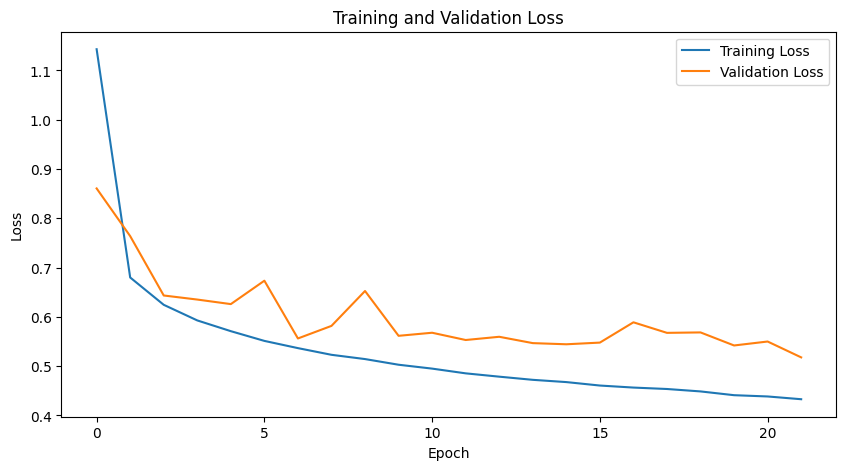

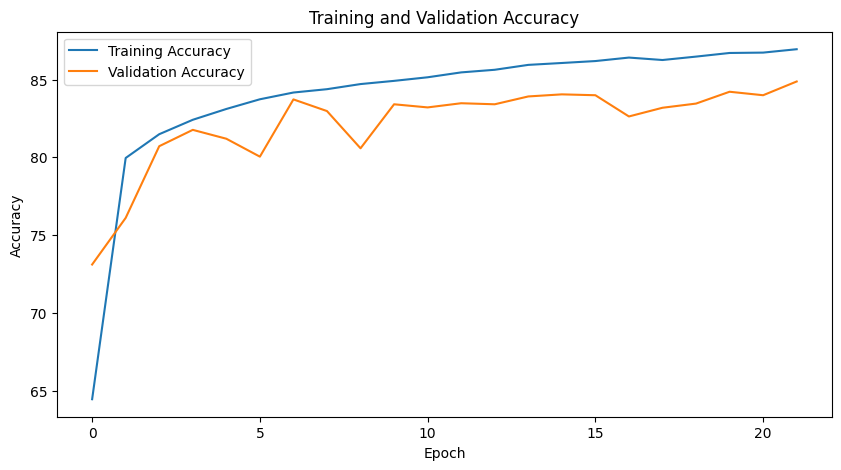

In [12]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(best_train_losses, label='Training Loss')
plt.plot(best_val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(best_train_accuracies, label='Training Accuracy')
plt.plot(best_val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [22]:
svhn_best_hyperparams = {'learning_rate': 0.001, 'batch_size': 32, 'optimizer': 'Adam', 'activation': 'ReLU'}
svhn_model_path = "svhn_best_model.pth"

Test Accuracy: 86.37%, Test Precision: 0.8650, Test Recall: 0.8443


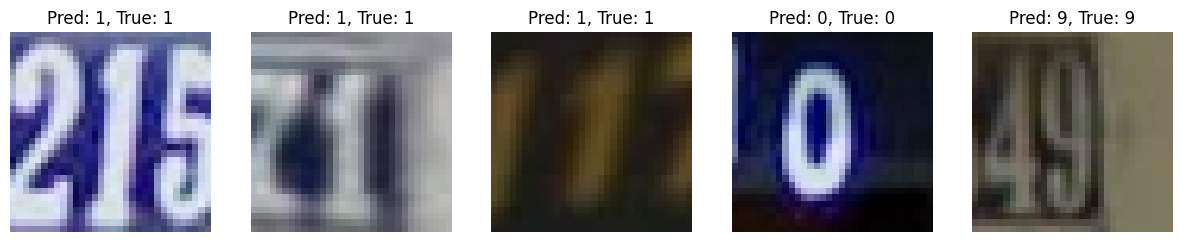

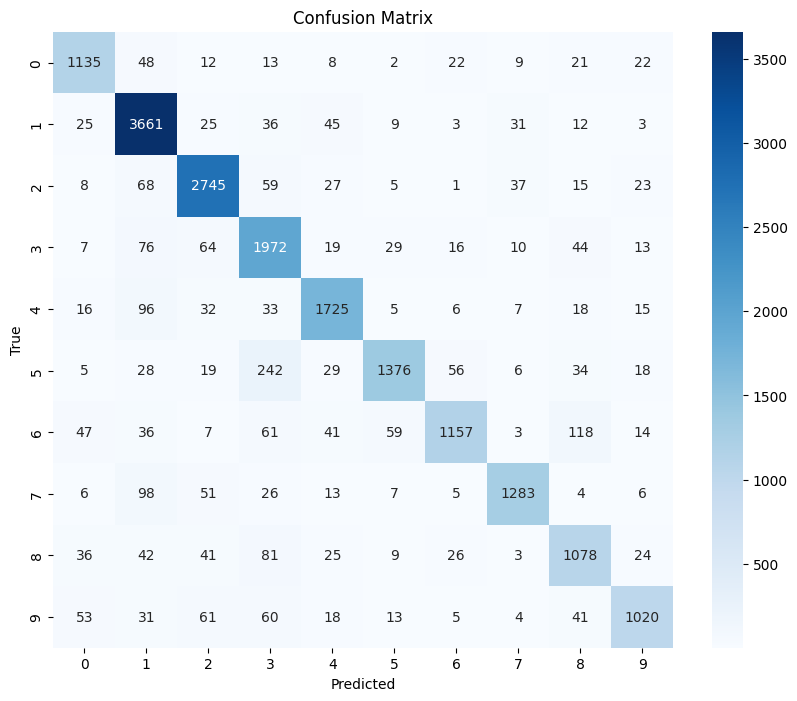

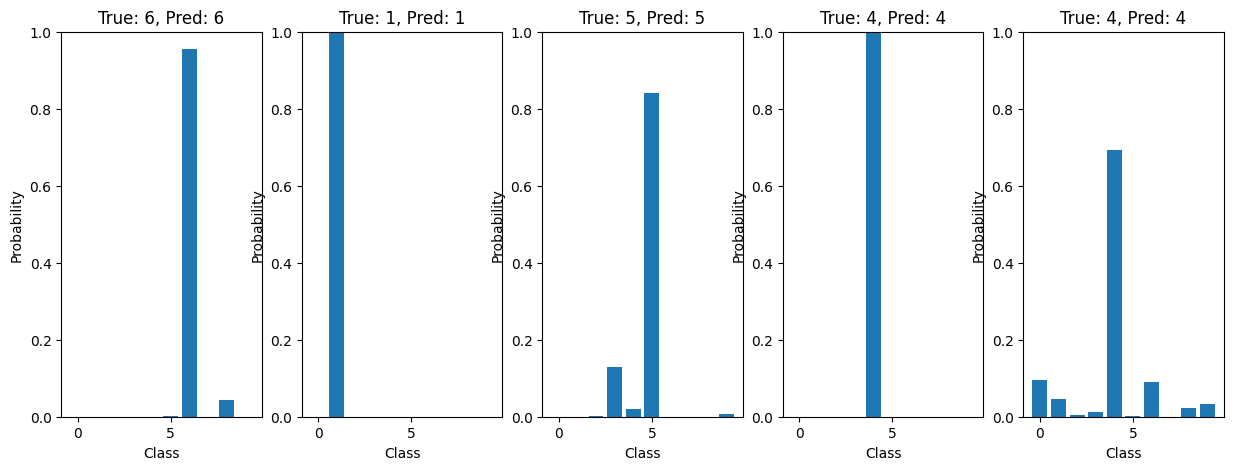

Class-wise Performance:
Class 0: Precision = 0.8483, Recall = 0.8785, F1 = 0.8631
Class 1: Precision = 0.8750, Recall = 0.9509, F1 = 0.9114
Class 2: Precision = 0.8979, Recall = 0.9187, F1 = 0.9082
Class 3: Precision = 0.7635, Recall = 0.8764, F1 = 0.8161
Class 4: Precision = 0.8846, Recall = 0.8833, F1 = 0.8839
Class 5: Precision = 0.9089, Recall = 0.7590, F1 = 0.8272
Class 6: Precision = 0.8921, Recall = 0.7498, F1 = 0.8148
Class 7: Precision = 0.9210, Recall = 0.8559, F1 = 0.8873
Class 8: Precision = 0.7783, Recall = 0.7897, F1 = 0.7840
Class 9: Precision = 0.8808, Recall = 0.7810, F1 = 0.8279


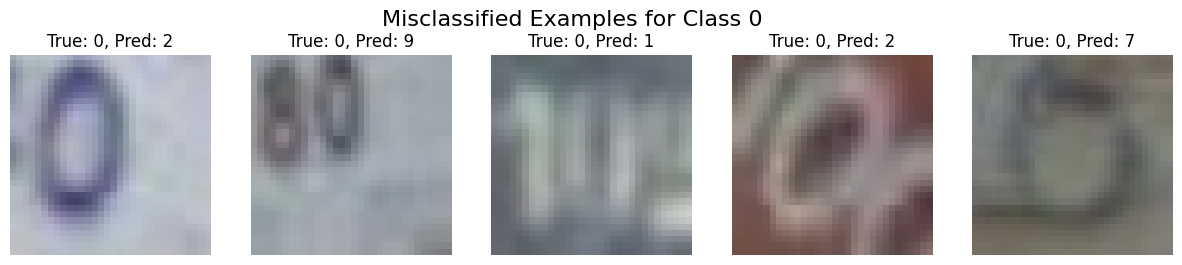

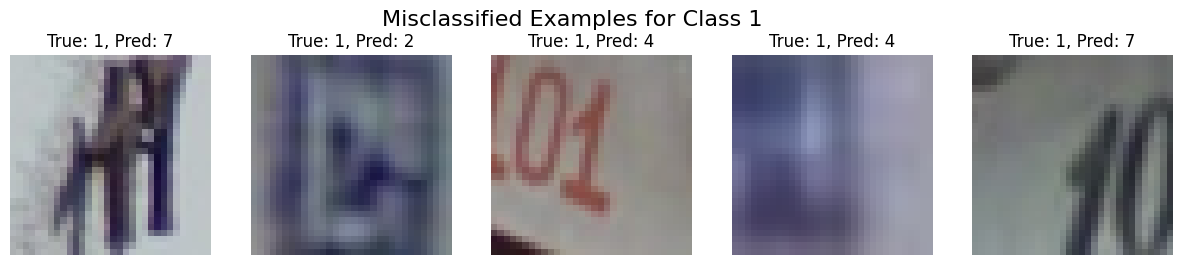

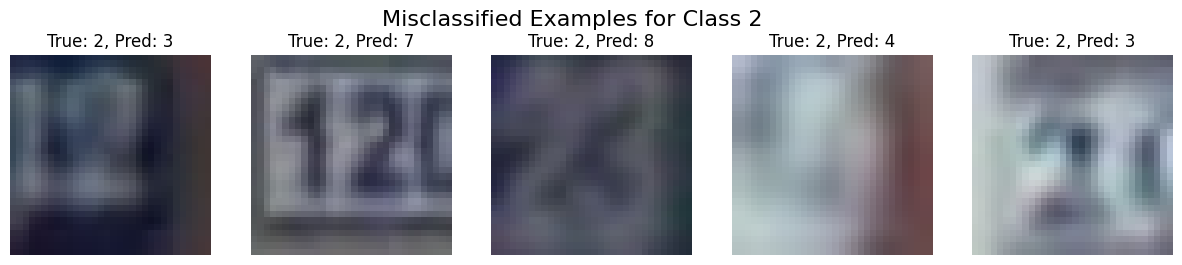

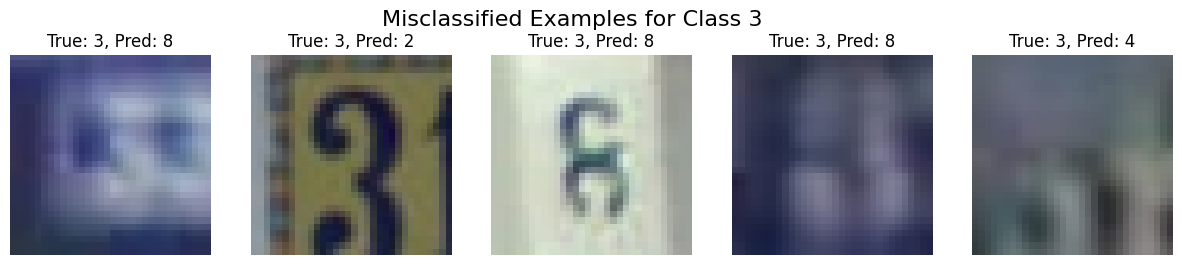

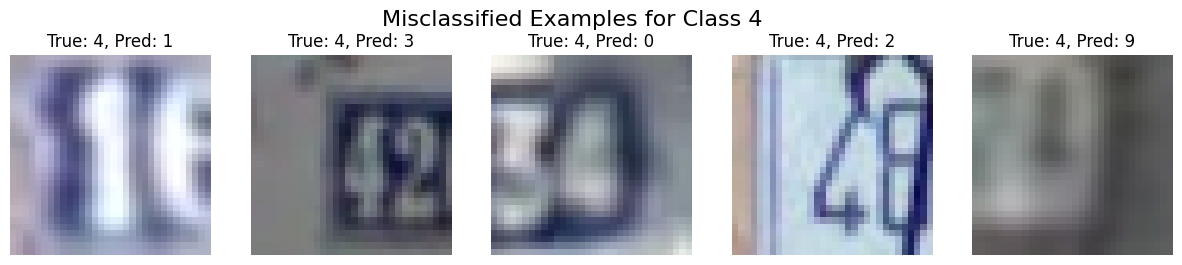

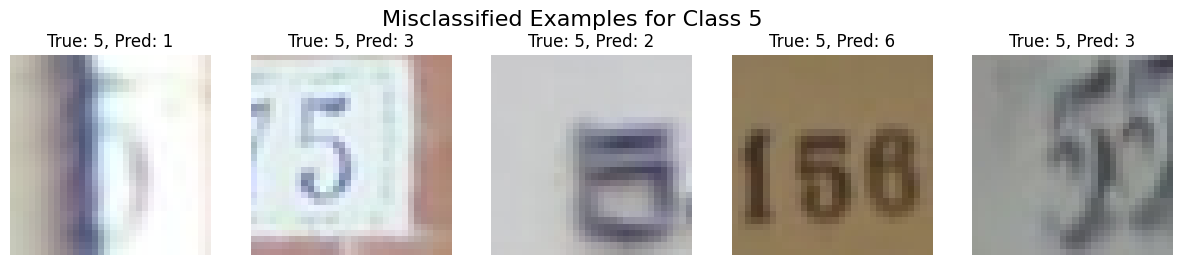

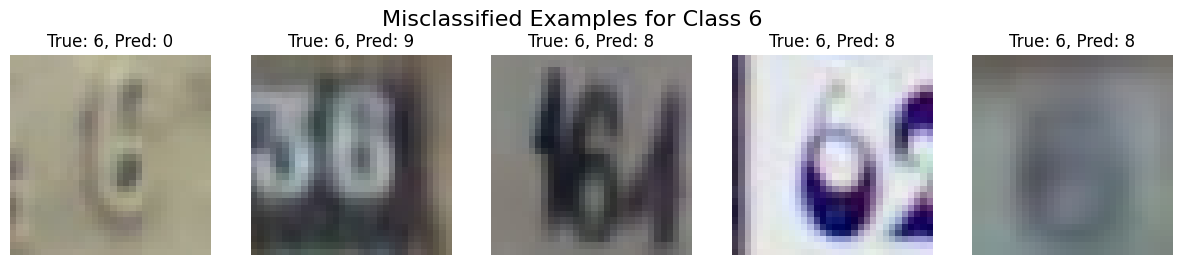

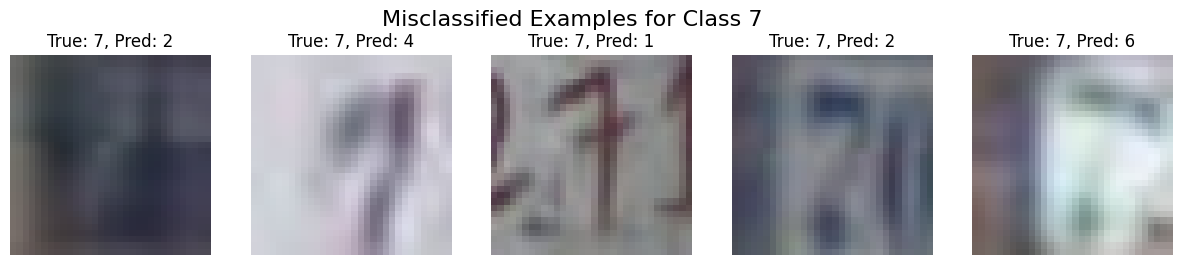

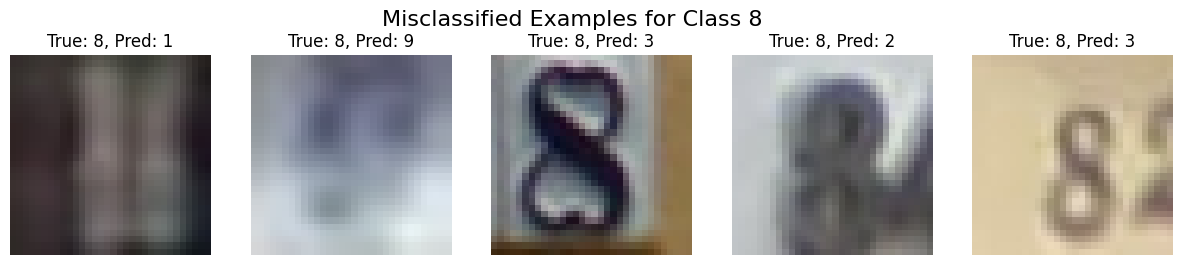

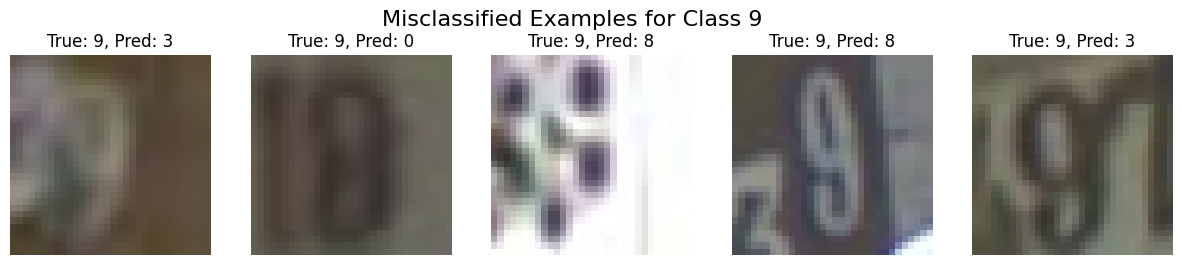

In [27]:
# Load the best model
svhn_best_model = CNN(activation=svhn_best_hyperparams['activation'], input_size=(3, 32, 32))
svhn_best_model.load_state_dict(torch.load(svhn_model_path, map_location=torch.device('cpu'), weights_only=True))
svhn_best_model.eval()

# Evaluate on test set
svhn_test_loader = DataLoader(svhn_test, batch_size=svhn_best_hyperparams['batch_size'], shuffle=False)
all_preds, all_labels = [], []
all_images, all_probabilities = [], []  # Store images and softmax probabilities

with torch.no_grad():
    for inputs, labels in svhn_test_loader:
        outputs = svhn_best_model(inputs)
        probabilities = torch.softmax(outputs, dim=1)  # Get softmax probabilities
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_images.extend(inputs.cpu().numpy())  # Store images
        all_probabilities.extend(probabilities.cpu().numpy())  # Store probabilities

# Convert lists to numpy arrays for easier manipulation
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_images = np.array(all_images)
all_probabilities = np.array(all_probabilities)

# Calculate test metrics
test_accuracy = 100 * (np.array(all_preds) == np.array(all_labels)).mean()
test_precision = precision_score(all_labels, all_preds, average='macro')
test_recall = recall_score(all_labels, all_preds, average='macro')
print(f"Test Accuracy: {test_accuracy:.2f}%, Test Precision: {test_precision:.4f}, Test Recall: {test_recall:.4f}")

# Demonstrate inference on random samples
demonstrate_inference(svhn_test_loader, svhn_best_model)

# Plot confusion matrix for SVHN
class_names = [str(i) for i in range(10)]  # SVHN classes are digits 0-9
plot_confusion_matrix(all_labels, all_preds, class_names)

# Visualize probability maps for random samples
random_indices = np.random.choice(len(all_probabilities), size=5, replace=False)
visualize_probability_maps(np.array(all_probabilities)[random_indices], np.array(all_labels)[random_indices], np.array(all_preds)[random_indices])

# Analyze performance per class
analyze_per_class_performance(all_labels, all_preds, class_names)

# Visualize misclassified examples for each class
visualize_misclassified_examples(all_images, all_labels, all_preds, class_names, num_samples=5)

# 3. Model Evaluation and Visualization

## Extract Features and Apply UMAP

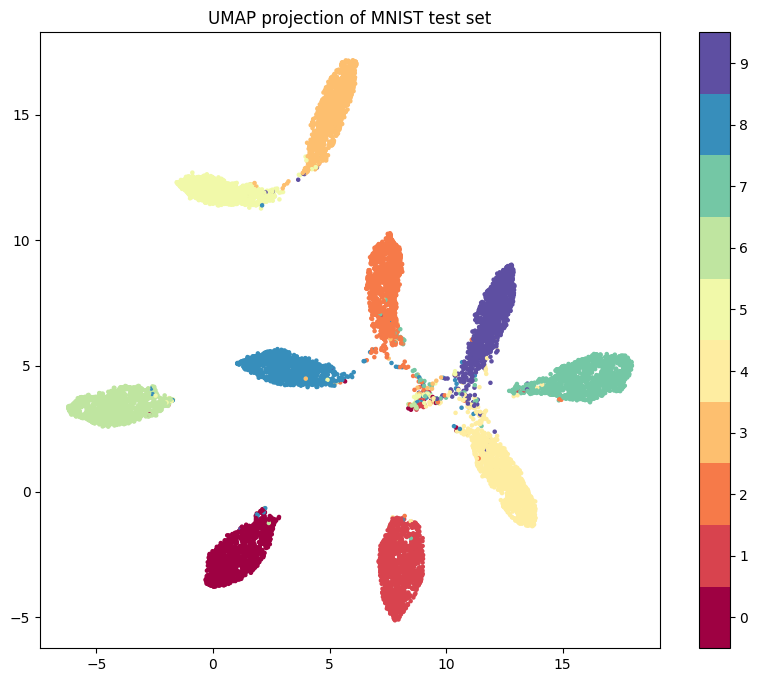

In [51]:
def extract_features(model, data_loader):
    model.eval()
    features_list = []
    labels_list = []
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            features = model(inputs)
            features_list.append(features.cpu().numpy())
            labels_list.append(labels.cpu().numpy())
    features = np.concatenate(features_list, axis=0)
    labels = np.concatenate(labels_list, axis=0)
    return features, labels

# Extract features from the MNIST test set
mnist_features, mnist_labels = extract_features(mnist_best_model, mnist_test_loader)

# Apply UMAP for dimensionality reduction
reducer = umap.UMAP(n_components=2)
mnist_umap = reducer.fit_transform(mnist_features)

# Plot the UMAP results
plt.figure(figsize=(10, 8))
plt.scatter(mnist_umap[:, 0], mnist_umap[:, 1], c=mnist_labels, cmap='Spectral', s=5)
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('UMAP projection of MNIST test set')
plt.show()

## Repeat for SVHN

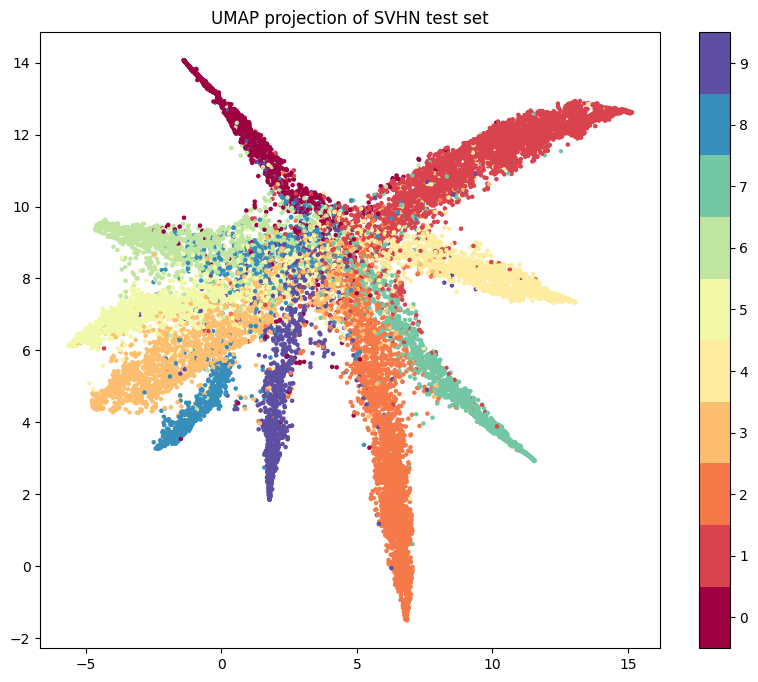

In [52]:
# Extract features from the SVHN test set
svhn_features, svhn_labels = extract_features(svhn_best_model, svhn_test_loader)

# Apply UMAP for dimensionality reduction
svhn_umap = reducer.fit_transform(svhn_features)

# Plot the UMAP results
plt.figure(figsize=(10, 8))
plt.scatter(svhn_umap[:, 0], svhn_umap[:, 1], c=svhn_labels, cmap='Spectral', s=5)
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('UMAP projection of SVHN test set')
plt.show()

# 4. Imbalanced Class Training and Analysis

## Function to load MNIST data with different cases

In [64]:
def load_mnist_data(data, case):
    if case == 1: # 50 samples of class '1' and 1000 samples of class '2'.
        class_1_indices = [i for i, (x, y) in enumerate(data) if y == 1][:50]
        class_2_indices = [i for i, (x, y) in enumerate(data) if y == 2][:1000]
    elif case == 2:
        class_1_indices = [i for i, (x, y) in enumerate(data) if y == 1][:500]
        class_2_indices = [i for i, (x, y) in enumerate(data) if y == 2][:1000]
    elif case == 3:
        class_1_indices = [i for i, (x, y) in enumerate(data) if y == 1]
        class_2_indices = [i for i, (x, y) in enumerate(data) if y == 2]

    selected_indices = class_1_indices + class_2_indices
    subset = Subset(data, selected_indices)

    train_loader = DataLoader(subset, batch_size=32, shuffle=True)

    return train_loader


## The training function

In [72]:
def train_and_evaluate(train_loader, test_loader, input_size=(3, 28, 28), epochs=50):
    model = CNN(input_size=input_size)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(epochs):
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = 100 * (np.array(all_preds) == np.array(all_labels)).mean()
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')

    print(f"Accuracy: {accuracy:.2f}%, Precision: {precision:.4f}, Recall: {recall:.4f}")


## Function to plot the UMAP results

In [66]:
def plot_umap(model, test_loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    embeddings, labels = [], []
    with torch.no_grad():
        for inputs, lbls in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            embeddings.extend(outputs.cpu().numpy())
            labels.extend(lbls.numpy())

    reducer = umap.UMAP()
    umap_embeddings = reducer.fit_transform(embeddings)

    plt.figure(figsize=(10, 8))
    plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=labels, cmap='Spectral', s=5)
    plt.colorbar(boundaries=np.arange(3)+0.5).set_ticks([1, 2])
    plt.title('UMAP projection of the test set')
    plt.show()


## Train the MNIST model using the following class distributions for 50 epochs:

In [56]:
# Filter the test set to include only labels 1 and 2
mnist_test_loader_filtered = load_mnist_data(mnist_test, case=3)
print(f"Number of samples in the filtered test set: {len(mnist_test_loader_filtered.dataset)}")


Number of samples in the filtered test set: 2925


Number of samples in the new training dataset: 1050
Accuracy: 99.25%, Precision: 0.9924, Recall: 0.9926


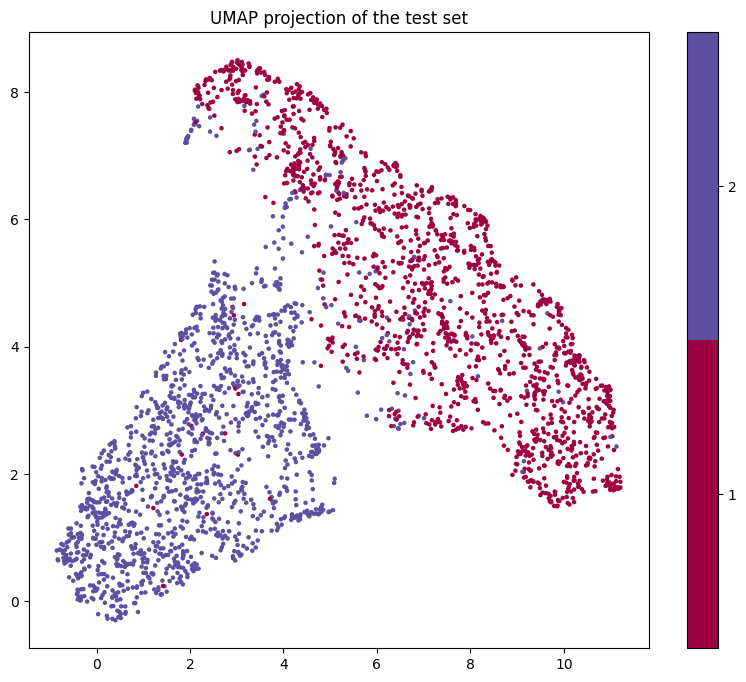

In [57]:
# Filter the training set for Case 1
mnist_train_loader_case1 = load_mnist_data(mnist_train, case=1)
print(f"Number of samples in the new training dataset: {len(mnist_train_loader_case1.dataset)}")

# Train and evaluate the model
model = CNN()
train_and_evaluate(mnist_train_loader_case1, mnist_test_loader_filtered)

# Plot UMAP
plot_umap(model, mnist_test_loader_filtered)

Number of samples in the new training dataset: 1500
Accuracy: 99.56%, Precision: 0.9955, Recall: 0.9956


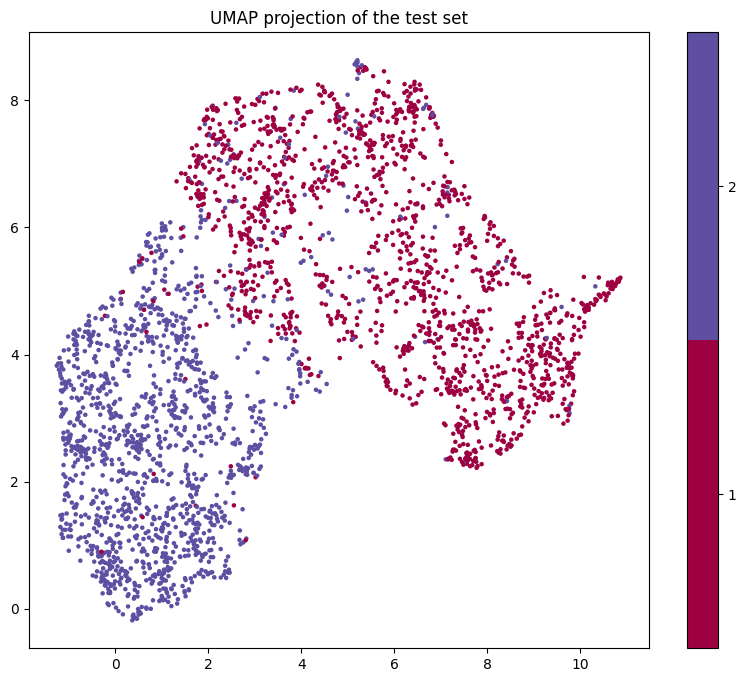

In [58]:
# Filter the training set for Case 2
mnist_train_loader_case2 = load_mnist_data(mnist_train, case=2)
print(f"Number of samples in the new training dataset: {len(mnist_train_loader_case2.dataset)}")

# Train and evaluate the model
model = CNN()
train_and_evaluate(mnist_train_loader_case2, mnist_test_loader_filtered)

# Plot UMAP
plot_umap(model, mnist_test_loader_filtered)

Number of samples in the new training dataset: 10496
Accuracy: 99.90%, Precision: 0.9990, Recall: 0.9990


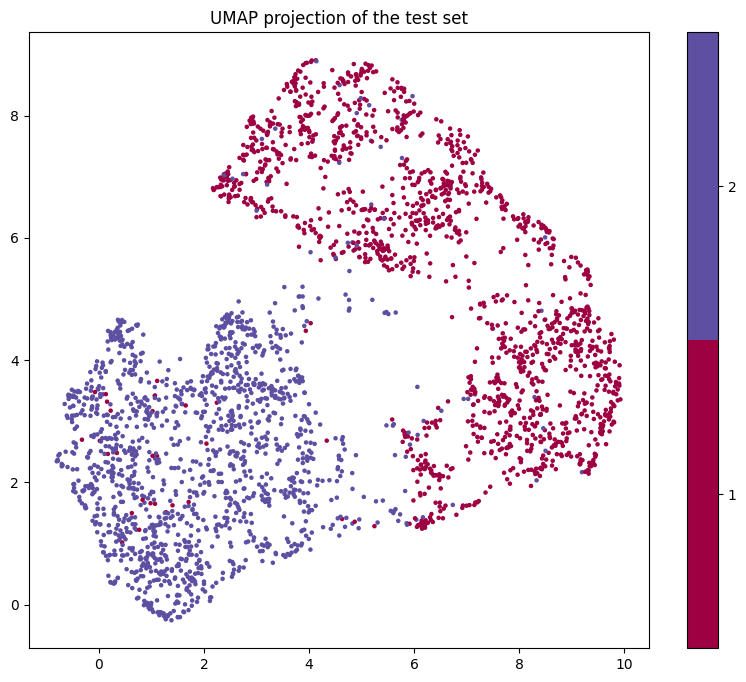

In [59]:
# Filter the training set for Case 3
mnist_train_loader_case3 = load_mnist_data(mnist_train, case=3)
print(f"Number of samples in the new training dataset: {len(mnist_train_loader_case3.dataset)}")

# Train and evaluate the model
model = CNN()
train_and_evaluate(mnist_train_loader_case3, mnist_test_loader_filtered)

# Plot UMAP
plot_umap(model, mnist_test_loader_filtered)

## Similarly for the SVHN dataset

Number of samples in the filtered test set: 6838
Number of samples in the new training dataset(case 1): 1050
Accuracy: 80.29%, Precision: 0.8411, Recall: 0.8241


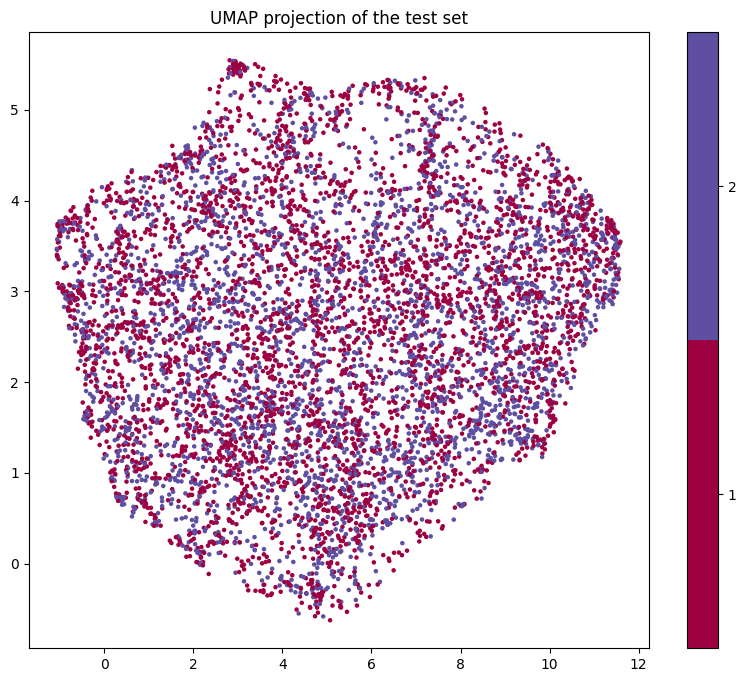

Number of samples in the new training dataset(case 2): 1500
Accuracy: 95.79%, Precision: 0.9558, Recall: 0.9597


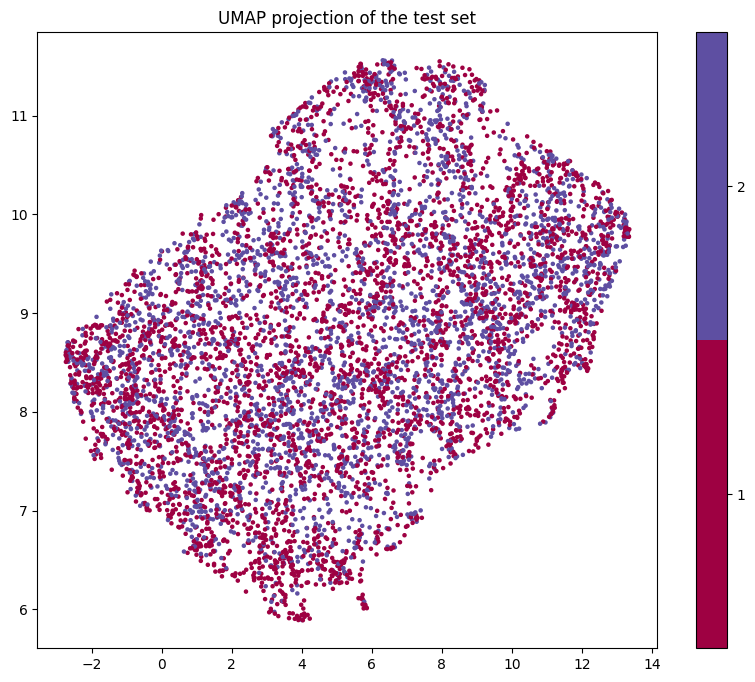

Number of samples in the new training dataset(case 3): 23558
Accuracy: 98.14%, Precision: 0.9814, Recall: 0.9809


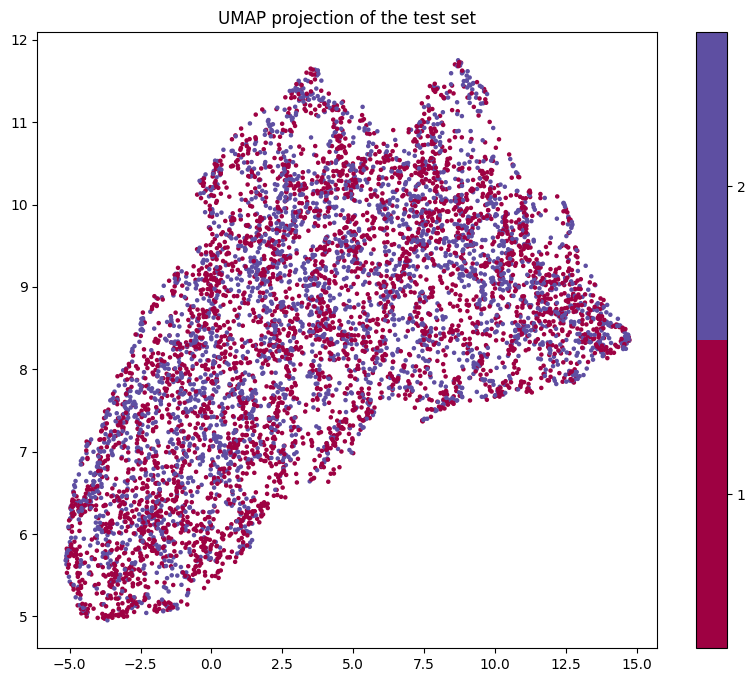

In [73]:
# Filter the test set to include only labels 1 and 2
svhn_test_loader_filtered = load_mnist_data(svhn_test, case=3)
print(f"Number of samples in the filtered test set: {len(svhn_test_loader_filtered.dataset)}")

## Filter the training set for Case 1
svhn_train_loader_case1 = load_mnist_data(svhn_train, case=1)
print(f"Number of samples in the new training dataset(case 1): {len(svhn_train_loader_case1.dataset)}")

# Train and evaluate the model
model = CNN(input_size=(3, 32, 32))
train_and_evaluate(svhn_train_loader_case1, svhn_test_loader_filtered, input_size=(3, 32, 32))

# Plot UMAP
plot_umap(model, svhn_test_loader_filtered)


## Filter the training set for Case 2
svhn_train_loader_case2 = load_mnist_data(svhn_train, case=2)
print(f"Number of samples in the new training dataset(case 2): {len(svhn_train_loader_case2.dataset)}")

# Train and evaluate the model
model = CNN(input_size=(3, 32, 32))
train_and_evaluate(svhn_train_loader_case2, svhn_test_loader_filtered, input_size=(3, 32, 32))

# Plot UMAP
plot_umap(model, svhn_test_loader_filtered)


## Filter the training set for Case 1
svhn_train_loader_case3 = load_mnist_data(svhn_train, case=3)
print(f"Number of samples in the new training dataset(case 3): {len(svhn_train_loader_case3.dataset)}")

# Train and evaluate the model
model = CNN(input_size=(3, 32, 32))
train_and_evaluate(svhn_train_loader_case3, svhn_test_loader_filtered, input_size=(3, 32, 32))

# Plot UMAP
plot_umap(model, svhn_test_loader_filtered)
